# Cphase gate simulation in spin qubit
Author: Jiheng Duan

Email: jiheng.duan@rochester.edu

In [1]:
import sys
# This on is a path correcting code, which is used to find the path of QuSim.
sys.path.append('../../..')
import QuSim.DataPlot.plot_lib as pl
import QuSim.Instruments.tools as tools
import QuSim.Instruments.stochastic_gen as sg
import QuSim.System.arb_qubit_system as aqs
import QuSim.Instruments.angle as  ang
from QuSim.Instruments.angle import get_angle

import numpy as np
import matplotlib.pyplot as plt

from tqdm import *
from time import *
from sympy import*
import copy
import pickle
from qutip import*

def var_name2str(variable):
    def nested_var_name2str(value):
        if isinstance(value, list):
            return [nested_var_name2str(item) for item in value]
        else:
            for name in globals():
                if eval(name) == value:
                    return name
            return str(value)
    return nested_var_name2str(variable)

# Print the full output
np.set_printoptions(threshold=sys.maxsize)

# auto reload
%load_ext autoreload
%autoreload 2 

## Logic qubit case
### Define system

We start from logic qubit.

Referring to https://journals.aps.org/prb/pdf/10.1103/PhysRevB.90.045418

The effective Hamiltonian for two qubit is given by
$$
H_{eff} = (\mu \Delta_{12} + \bar{B}) \sigma_z^1 + (\mu \Delta_{34} + \bar{B}) \sigma_z^2 + J_{23}/4 (\sigma_z^1 \sigma_z^2 - II)
$$

Here, we reduce this to 

$$
H_{eff} = \omega_1 \sigma_z^1 + \omega_2 \sigma_z^2 + J_{12}\sigma_x^1 + J_{34}\sigma_x^2 +  \chi \sigma_z^1 \sigma_z^2
$$


In [2]:
int_strength = 0.2e-3 # 0.2MHz
freq_list = [
    [0, 0.3],
    [0, 0.4]
]

inter_list = [
    {
        "v01": 0,
        "v00": 1,
        "v11": -1
    },
    {
        "v01": 0,
        "v00": 1,
        "v11": -1
    }
]

r_dic = {
    "r12": int_strength
}
r = tools.r2matrix(r_dic, freq_list) # Coupling strength

# extra_list = [
#     {
#         "v01": 2e-3
#     },
#     {
#         "v01": 3.1e-3
#     }
# ]
extra_list = None

## with pulse type XY
driving_list = [
    {
        "W01": 1j   # W01 represents \Omega_{01}, for the qubit with index 0
    },
    {
        "W01": 1j
    }
]

## with pulse type Z
bias_list = [ # Default, Z00 = 0
    {
        "Z11": 1
    },
    {
        "Z11": 1
    }
]

gamma_list = None

# gamma_list = None

_system_arb1 = aqs.arb_qubit_system(freq_list, inter_list, r, extra_list, gamma_list, driving_list, bias_list)

state_00, E_00, index_00 = _system_arb1.get_eigenstates_energy((0,0))
state_01, E_01, index_01 = _system_arb1.get_eigenstates_energy((0,1))
state_10, E_10, index_10 = _system_arb1.get_eigenstates_energy((1,0))
state_11, E_11, index_11 = _system_arb1.get_eigenstates_energy((1,1))

_system_arb1.H

Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = True
Qobj data =
[[1.25663706e-03 0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.51201749e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.88369896e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 4.39948635e+00]]

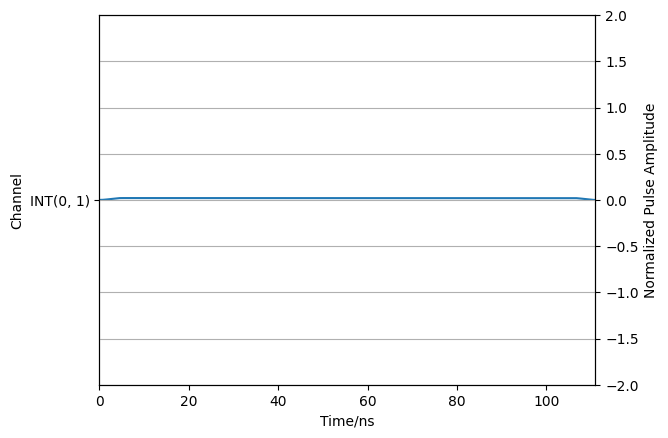

0

In [431]:
t_width = 10; bisa_amp = 20e-3

simulation_option = {
    "simulation_time": 111, # ns
    "simulation_step": 10000,
    "initial_state": [state_00, state_01, state_10, state_11] # Do multiple simulation
}

noise_chan1 = [
    {
    'type': 'white',
    'switch': 'off',
    'std': bisa_amp*0.3,
    }
]
noise_chan2 = [
    {
    'type': '1/f',
    'switch': 'on',
    'scale': 0.3,
    'alpha': 0.9,
    }
]
noise_chan3 = [
    {
    'type': '1/f',
    'switch': 'on',
    'scale': 0.12,
    'alpha': 0.92,
    }
]
noise_chan4 = [
    {
    'type': 'gaussian',
    'switch': 'on',
    'mean': 0,
    'std': 0.2
    }
]
noise_chan5 = [
    {
    'type': 'gaussian',
    'switch': 'on',
    'mean':0,
    'std': 0.1
    }
]

pulse_sequence = [
    {
        'pulse_index': 0, # [m,n] represents $\Omega_{mn}$
        'type': "INT",
        'pulse_shape': "cosine",
        't_delay': 0, # unit in ns
        't_width': t_width, # unit in ns
        't_plateau':simulation_option['simulation_time'] - t_width , # unit in ns
        'freq': 0, # unit in GHz; Z pulse does not use it
        'phase': 0, # unit in rad; Z pulse does not use it
        'amplitude': bisa_amp, # XY: Rabi freq; Z: biased frequency
        'q_index': (0,1),
        'noise': noise_chan1
    },
    # {
    #     'pulse_index': 1,
    #     'type': "Z",
    #     "pulse_shape": "square",
    #     't_delay': 0, # unit in ns
    #     't_width': 0, # unit in ns
    #     't_plateau':simulation_option['simulation_time'], # unit in ns
    #     'freq': 0, # unit in GHz; Z pulse does not use it
    #     'phase': 0, # unit in rad; Z pulse does not use it
    #     'amplitude': 0, # XY: Rabi freq; Z: biased frequency
    #     'q_index': 0,
    #     'noise': noise_chan2
    # },
    # {
    #     'pulse_index': 2,
    #     'type': "Z",
    #     "pulse_shape": "square",
    #     't_delay': 0, # unit in ns
    #     't_width': 0, # unit in ns
    #     't_plateau':simulation_option['simulation_time'], # unit in ns
    #     'freq': 0, # unit in GHz; Z pulse does not use it
    #     'phase': 0, # unit in rad; Z pulse does not use it
    #     'amplitude': 0, # XY: Rabi freq; Z: biased frequency
    #     'q_index': 1,
    #     'noise': noise_chan3
    # },
    # {
    #     'pulse_index': 3,
    #     'type': "XY",
    #     "pulse_shape": "square",
    #     't_delay': 0, # unit in ns
    #     't_width': 0, # unit in ns
    #     't_plateau':simulation_option['simulation_time'], # unit in ns
    #     'freq': 0, # unit in GHz; Z pulse does not use it
    #     'phase': 0, # unit in rad; Z pulse does not use it
    #     'amplitude': 0, # XY: Rabi freq; Z: biased frequency
    #     'q_index': 0,
    #     'noise': noise_chan4
    # },
    # {
    #     'pulse_index': 4,
    #     'type': "XY",
    #     "pulse_shape": "square",
    #     't_delay': 0, # unit in ns
    #     't_width': 0, # unit in ns
    #     't_plateau':simulation_option['simulation_time'], # unit in ns
    #     'freq': 0, # unit in GHz; Z pulse does not use it
    #     'phase': 0, # unit in rad; Z pulse does not use it
    #     'amplitude': 0, # XY: Rabi freq; Z: biased frequency
    #     'q_index': 1,
    #     'noise': noise_chan5
    # }
]

%matplotlib inline
## Notice that the all pulses'  amplitude are rescaled by a factor 1/1.2
pl.plot_pulse_sequence(pulse_sequence, simulation_option)

In [432]:
result_list, angle_list = _system_arb1.system_dynamics_mesolve(simulation_option, pulse_sequence)
propa_list = _system_arb1.system_dynamics_propagator(simulation_option, pulse_sequence)
angle_list

25.0%. Run time:   2.63s. Est. time left: 00:00:00:07
50.0%. Run time:   2.75s. Est. time left: 00:00:00:02
75.0%. Run time:   3.07s. Est. time left: 00:00:00:01
100.0%. Run time:   3.13s. Est. time left: 00:00:00:00
Total run time:   3.18s


[array([[5.38971886]]),
 array([[4.66343237]]),
 array([[5.29175071]]),
 array([[0.99154325]])]

In [433]:
U = propa_list[-1]
Usim = U/U.data[0,0]
Usim

Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = False
Qobj data =
[[ 1.        +0.j          0.        +0.j          0.        +0.j
   0.        +0.j        ]
 [ 0.        +0.j          0.74764569-0.66409783j  0.        +0.j
   0.        +0.j        ]
 [ 0.        +0.j          0.        +0.j          0.99520496-0.09781151j
   0.        +0.j        ]
 [ 0.        +0.j          0.        +0.j          0.        +0.j
  -0.30906845+0.95103979j]]

In [434]:
# Construct a decoupled system
r_dic = {
    "r12": 0
}
r = tools.r2matrix(r_dic, freq_list) # Coupling strength
extra_list=None
_system_arb2 = aqs.arb_qubit_system(freq_list, inter_list, r, extra_list, gamma_list, driving_list, bias_list)

state_00, E_00, index_00 = _system_arb2.get_eigenstates_energy((0,0))
state_01, E_01, index_01 = _system_arb2.get_eigenstates_energy((0,1))
state_10, E_10, index_10 = _system_arb2.get_eigenstates_energy((1,0))
state_11, E_11, index_11 = _system_arb2.get_eigenstates_energy((1,1))
simulation_option2 = copy.deepcopy(simulation_option)
simulation_option2['initial_state'] = [state_00, state_01, state_10, state_11]
# simulation_option2['simulation_time'] = 154
pulse_sequence2 = [
    {
        'pulse_index': 1, # [m,n] represents $\Omega_{mn}$
        'type': "INT",
        'pulse_shape': "cosine",
        't_delay': 0, # unit in ns
        't_width': t_width, # unit in ns
        't_plateau':simulation_option2['simulation_time'] - t_width , # unit in ns
        'freq': 0, # unit in GHz; Z pulse does not use it
        'phase': 0, # unit in rad; Z pulse does not use it
        'amplitude': 0, # XY: Rabi freq; Z: biased frequency
        'q_index': (0,1)
    }
]

result_list2, angle_list2 = _system_arb2.system_dynamics_mesolve(simulation_option2, pulse_sequence2)
angle_list2

[array([[0.]]),
 array([[3.7699635]]),
 array([[4.39828178]]),
 array([[1.88501191]])]

In [435]:
q_pmatrix = np.array([[1,0,0,0], 
              [0, np.exp(-1j*angle_list2[1][0][0]), 0, 0],
              [0,0, np.exp(-1j*angle_list2[2][0][0]), 0],
              [0,0,0, np.exp(-1j *angle_list2[3][0][0])]])
# single qubit rotation correcting phase gate during ZZ inter
q_phase_gate = Qobj(q_pmatrix,
              dims = [[2,2], [2,2]])
q_phase_gate

Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = False
Qobj data =
[[ 1.        +0.j          0.        +0.j          0.        +0.j
   0.        +0.j        ]
 [ 0.        +0.j         -0.80898624+0.58782757j  0.        +0.j
   0.        +0.j        ]
 [ 0.        +0.j          0.        +0.j         -0.30896748+0.9510726j
   0.        +0.j        ]
 [ 0.        +0.j          0.        +0.j          0.        +0.j
  -0.30907055-0.95103911j]]

In [436]:
# Correcting single qubit phase during ZZ inter
Usim_p = Usim * q_phase_gate
Usim_p

Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = False
Qobj data =
[[ 1.        +0.00000000e+00j  0.        +0.00000000e+00j
   0.        +0.00000000e+00j  0.        +0.00000000e+00j]
 [ 0.        +0.00000000e+00j -0.21446006+9.76732760e-01j
   0.        +0.00000000e+00j  0.        +0.00000000e+00j]
 [ 0.        +0.00000000e+00j  0.        +0.00000000e+00j
  -0.21446012+9.76732746e-01j  0.        +0.00000000e+00j]
 [ 0.        +0.00000000e+00j  0.        +0.00000000e+00j
   0.        +0.00000000e+00j  1.        -2.20838679e-06j]]

In [19]:
# Phase gate after ZZ inter, correcting single qubit phase
phi12 = -np.angle(Usim_p.data[1,1])
c_pmatrix = np.array([[1,0,0,0], 
              [0, np.exp(1j*phi12), 0, 0],
              [0,0, np.exp(1j*phi12), 0],
              [0,0,0, np.exp(1j *2*phi12)]])
# correcting phase gate
c_phase_gate = Qobj(c_pmatrix,
              dims = [[2,2], [2,2]])
c_phase_gate

Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = False
Qobj data =
[[ 1.        +0.j          0.        +0.j          0.        +0.j
   0.        +0.j        ]
 [ 0.        +0.j         -0.13601307-0.99070704j  0.        +0.j
   0.        +0.j        ]
 [ 0.        +0.j          0.        +0.j         -0.13601307-0.99070704j
   0.        +0.j        ]
 [ 0.        +0.j          0.        +0.j          0.        +0.j
  -0.96300089+0.26949821j]]

In [20]:
Uphase = Usim_p * c_phase_gate
Uphase

Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = False
Qobj data =
[[ 1.00000000e+00+0.j          9.57395942e-02-0.01135327j
   2.18804317e-01-0.04239666j  2.52177950e-03+0.00382085j]
 [-9.31898936e-02-0.01478346j  1.02174069e+00+0.j
  -1.81228326e-02+0.01650461j -5.73855167e-02+0.0473042j ]
 [-2.13688423e-01-0.0590355j  -8.07246633e-04+0.00660712j
   9.94354307e-01+0.07493354j -4.12229317e-02-0.11722557j]
 [ 1.54109863e-02-0.02645222j -6.96384749e-02-0.0290728j
  -1.23600087e-02+0.11918943j -9.74235610e-01+0.29809416j]]

#### Cal ideal Uphase

In [21]:
Uphase_ideal_matrix = np.array([[1,0,0,0], 
              [0, 1, 0, 0],
              [0,0, 1, 0],
              [0,0,0, np.exp(1j*2*phi12)]])
Uphase_ideal = Qobj(Uphase_ideal_matrix, dims= [[2,2], [2,2]])
Uphase_ideal


Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = False
Qobj data =
[[ 1.        +0.j          0.        +0.j          0.        +0.j
   0.        +0.j        ]
 [ 0.        +0.j          1.        +0.j          0.        +0.j
   0.        +0.j        ]
 [ 0.        +0.j          0.        +0.j          1.        +0.j
   0.        +0.j        ]
 [ 0.        +0.j          0.        +0.j          0.        +0.j
  -0.96300089+0.26949821j]]

In [22]:
pickle.dump(Uphase_ideal_matrix, open('../../../Data/Uphase_ideal.pkl', 'wb'))

#### Load ideal Uphase and cal fidelity

In [23]:
Uphase_ideal_matrix = pickle.load(open('../../../Data/Uphase_ideal.pkl', 'rb'))
Uphase_ideal = Qobj(Uphase_ideal_matrix, dims= [[2,2], [2,2]])
Uphase_ideal

Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = False
Qobj data =
[[ 1.        +0.j          0.        +0.j          0.        +0.j
   0.        +0.j        ]
 [ 0.        +0.j          1.        +0.j          0.        +0.j
   0.        +0.j        ]
 [ 0.        +0.j          0.        +0.j          1.        +0.j
   0.        +0.j        ]
 [ 0.        +0.j          0.        +0.j          0.        +0.j
  -0.96300089+0.26949821j]]

In [24]:
f = (1/4*(Uphase_ideal*Uphase.dag()).tr())
f = abs(f)
print('Fidelity:{: .10%}'.format(f))##### fidelity

Fidelity: 100.8733918711%


In [55]:
Uphase

Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = False
Qobj data =
[[ 1.        +0.j         -0.04292607+0.00775256j -0.08833023+0.15147564j
   0.0088594 -0.00788683j]
 [ 0.04410601+0.00964278j  0.99784837+0.j          0.00801811-0.01237505j
  -0.0177106 -0.18580702j]
 [ 0.08671428+0.1523959j  -0.01484529+0.00155633j  0.99516605+0.00985924j
  -0.10663105+0.00122122j]
 [-0.00263655+0.0010269j   0.07986761+0.16906934j -0.09194397+0.0540306j
  -0.85672004+0.50246463j]]

## Physical spin case
### Define system

$$
H = \sum_{i=1}^4 \Delta B_z^i \sigma_z^i + \sum_{i=1}^3 J_{ij} \vec{\sigma}^i \cdot \vec{\sigma}^j
$$

or, effectively

* Single spin freq
$\omega_i = g\mu_B B_i$
here, $g=2$, $omega_i = [0, 15, 25, 28]$ MHz. Good case: $omega_i = [0, 150, 250, 350]$ MHz .

* Static coupling
$J_{ij} \approx 0.5\sim 1MHz$

* Bias amp: $J_{23} = 20 \sim 100 MHz$


In [87]:
freq_list = [ # GHz
    [0, 10.35],
    [0, 10],
    [0, 10.25],
    [0, 10.15]
]
inter_list = [
    [{
        "v01": 0,
        "v00": 1,
        "v11": -1
    },
    {
        "v01": 0,
        "v00": 1,
        "v11": -1
    }
    ,
    {
        "v01": 0,
        "v00": 1,
        "v11": -1
    },
    {
        "v01": 0,
        "v00": 1,
        "v11": -1
    }]
    ,
    [{
        "v01": 1,
        "v00": 0,
        "v11": 0
    },
    {
        "v01": 1,
        "v00": 0,
        "v11": 0
    }
    ,
    {
        "v01": 1,
        "v00": 0,
        "v11": 0
    },
    {
        "v01": 1,
        "v00": 0,
        "v11": 0
    }]
    ,
    [{
        "v01": -1j,
        "v00": 0,
        "v11": 0
    },
    {
        "v01": -1j,
        "v00": 0,
        "v11": 0
    }
    ,
    {
        "v01": -1j,
        "v00": 0,
        "v11": 0
    },
    {
        "v01": -1j,
        "v00": 0,
        "v11": 0
    }]
]
r_dic = { # 04/12/24 change residual coupling
    "r12": 1e-3,
    "r23": 1e-3,
    "r34": 1e-3
}
r = tools.r2matrix(r_dic, freq_list) 
extra_list=None
driving_list = [
    {
        "W01": 1j   # W01 represents \Omega_{01}, for the qubit with index 0
    },
    {
        "W01": 1j
    },
    {
        "W01": 1j
    },
    {
        "W01": 1j
    }
]
bias_list = [ 
    {
        "Z11": 1
    },
    {
        "Z11": 1
    },
    {
        "Z11": 1
    },
    {
        "Z11": 1
    }
]

gamma_list = None

_system_arb1 = aqs.arb_qubit_system(freq_list, inter_list, r, extra_list, gamma_list, driving_list, bias_list)

state_0000, E_0000, _= _system_arb1.get_eigenstates_energy((0,0,0,0))

state_0001, E_0001, _= _system_arb1.get_eigenstates_energy((0,0,0,1))
state_0010, E_0010, _= _system_arb1.get_eigenstates_energy((0,0,1,0))
state_0100, E_0100, _= _system_arb1.get_eigenstates_energy((0,1,0,0))
state_1000, E_1000, _= _system_arb1.get_eigenstates_energy((1,0,0,0))

"""subspace"""
state_0101, E_0101, index_0101= _system_arb1.get_eigenstates_energy((0,1,0,1))
state_1001, E_1001, index_1001= _system_arb1.get_eigenstates_energy((1,0,0,1))
state_0110, E_0110, index_0110= _system_arb1.get_eigenstates_energy((0,1,1,0))
state_1010, E_1010, index_1010= _system_arb1.get_eigenstates_energy((1,0,1,0))

"""leakage"""
state_0011, E_0011, index_0011= _system_arb1.get_eigenstates_energy((0,0,1,1))
state_1100, E_1100, index_1100= _system_arb1.get_eigenstates_energy((1,1,0,0))

state_0111, E_0111, _= _system_arb1.get_eigenstates_energy((0,1,1,1))
state_1011, E_1011, _= _system_arb1.get_eigenstates_energy((1,0,1,1))
state_1101, E_1101, _= _system_arb1.get_eigenstates_energy((1,1,0,1))
state_1110, E_1110, _= _system_arb1.get_eigenstates_energy((1,1,1,0))

state_1111, E_1111, _= _system_arb1.get_eigenstates_energy((1,1,1,1))

state_ud = Qobj(np.array([0,0,1,0]), dims = [[2, 2], [1, 1]], shape = (4, 1), type = ket)
state_du = Qobj(np.array([0,1,0,0]), dims = [[2, 2], [1, 1]], shape = (4, 1), type = ket)

state_dudu = tensor(state_du,state_du)
state_duud = tensor(state_du,state_ud)
state_uddu = tensor(state_ud,state_du)
state_udud = tensor(state_ud,state_ud)

_system_arb1.H

Quantum object: dims = [[2, 2, 2, 2], [2, 2, 2, 2]], shape = (16, 16), type = oper, isherm = True
Qobj data =
[[1.88495559e-02 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 6.37806141e+01 1.25663706e-02 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.25663706e-02 6.43963662e+01 0.00000000e+00
  1.25663706e-02 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 1.28183263e+02
  0.00000000e+00 1.25663706e-02 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.

### Energy level



#### $\omega_2$ scan

In [19]:
num_level = 16 # Num of level we want to see
w2_scan_space= np.linspace(9, 12, 800)
w =copy.deepcopy(freq_list)

energy_level_list = []
for w2 in w2_scan_space:
    dummy_list = []
    w[1][1] = w2
    _system_arb1 = aqs.arb_qubit_system(w, inter_list, r, extra_list, gamma_list, driving_list, bias_list)
    for j in range(0,num_level):
        dummy_list.append((_system_arb1.H.eigenenergies()[j] / np.pi/2).real)
    energy_level_list.append(dummy_list)

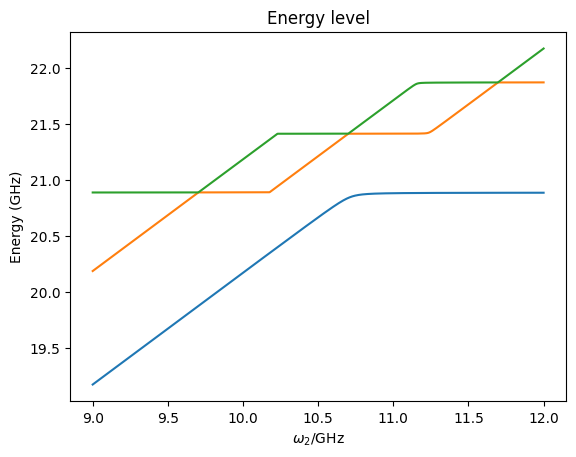

0

In [20]:
%matplotlib inline
pl.plot_Elevel_dynamics(w2_scan_space, energy_level_list, [index_0101, index_1100, index_0011], "\omega_2")

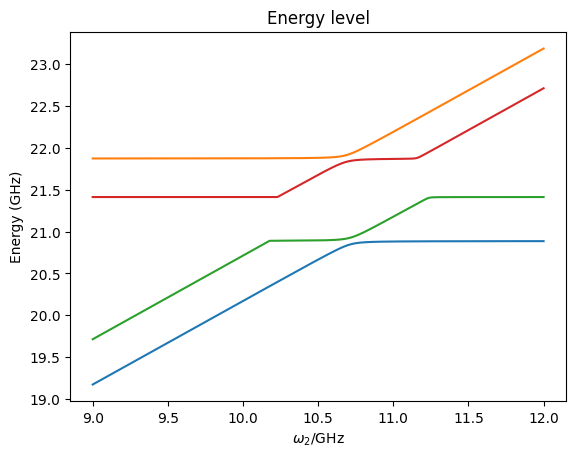

0

In [21]:
# %matplotlib qt
pl.plot_Elevel_dynamics(w2_scan_space, energy_level_list, [index_0101, index_1010, index_0110, index_1001], "\omega_2")

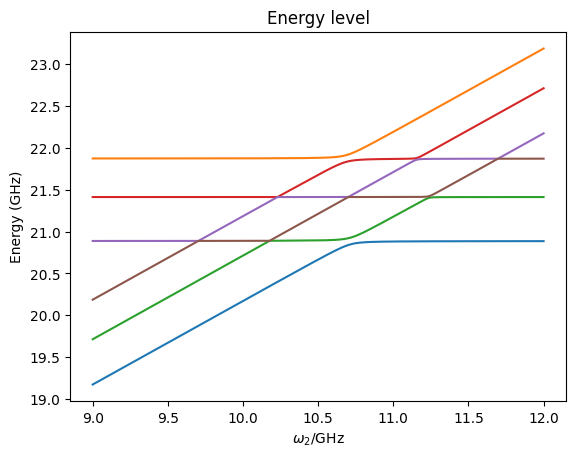

0

In [22]:
# %matplotlib qt
pl.plot_Elevel_dynamics(w2_scan_space, energy_level_list, [index_0101, index_1010, index_0110, index_1001, index_0011, index_1100], "\omega_2")

#### $J_{23}$ scan

In [486]:
num_level = 16 # Num of level we want to see
j23_scan_space= np.linspace(0.01e-3, 300e-3, 1000)
j_dic =copy.deepcopy(r_dic)

energy_level_list = []
for j23 in j23_scan_space:
    dummy_list = []
    j_dic["r23"] = j23
    j_matrix = tools.r2matrix(j_dic, freq_list)
    _system_arb1 = aqs.arb_qubit_system(freq_list, inter_list, j_matrix, extra_list, gamma_list, driving_list, bias_list)
    for j in range(0,num_level):
        dummy_list.append((_system_arb1.H.eigenenergies()[j] / np.pi/2).real)
    energy_level_list.append(dummy_list)

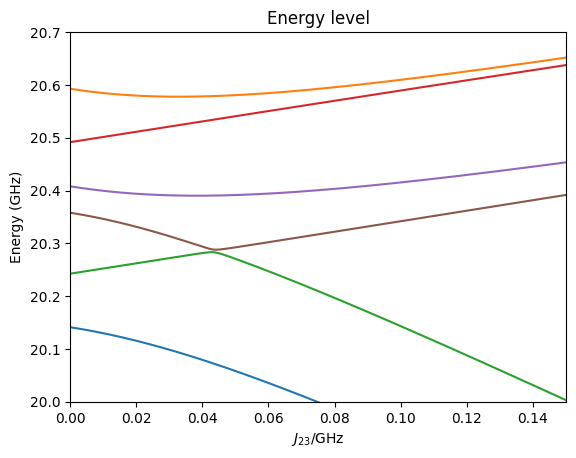

0

In [488]:
%matplotlib inline
pl.plot_Elevel_dynamics(j23_scan_space, energy_level_list, [index_0101, index_1010, index_0110, index_1001, index_0011, index_1100], "J_{23}", xrange=[0,150e-3], yrange=[20,20.7])

In [6]:
print(f'Subspace: E1010={E_1010}, E1001={E_1001}, E_0110={E_0110}, E0101={E_0101}')
print(f'Leakage space: E0011={E_0011}, E1100={E_1100}')

Subspace: E1010=20.58973531704359, E1001=20.497106910615866, E_0110=20.246854742870802, E0101=20.13833163005582
Leakage space: E0011=20.40324132216826, E1100=20.352730077245685


In [7]:
print(f'Subspace: index1010={index_1010}, index1001={index_1001}, Eindex0110={index_0110}, index0101={index_0101}')
print(f'Leakage space: index0011={index_0011}, index1100={index_1100}')

Subspace: index1010=10, index1001=9, Eindex0110=6, index0101=5
Leakage space: index0011=8, index1100=7


### System dynamics

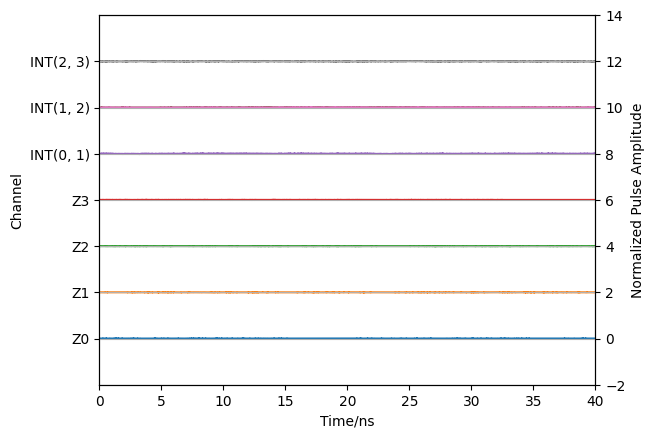

0

In [523]:
# t_width = 150; bisa_amp = 14.106e-3 
# or maybe 14.128e-3? as the baseline changed
bisa_amp = 11.128e-3; t_width = 40

simulation_option = {
    "simulation_time": t_width, # ns
    "simulation_step": 10000,
    "initial_state": [state_0101, state_0110, state_1001, state_1010] # Do multiple simulation
}

noise_chan1 = [
    {
    'type': 'white',
    'switch': 'on',
    'std': 1.43e-3,
    }
]
noise_chan2 = [
    {
    'type': 'gaussian',
    'switch': 'on',
    'mean': 0,
    'std': 1/(785),
    }
]
noise_chan3 = [
    {
    'type': '1/f',
    'switch': 'on',
    'scale': 0.002,
    'alpha': 1.2,
    }
]

pulse_sequence = [
    {
        'pulse_index': 0, # [m,n] represents $\Omega_{mn}$
        'type': "INT",
        'pulse_shape': "cosine",
        't_delay': 0, # unit in ns
        't_width': t_width, # unit in ns
        't_plateau':simulation_option['simulation_time'] - t_width , # unit in ns
        'freq': 0, # unit in GHz; Z pulse does not use it
        'phase': 0, # unit in rad; Z pulse does not use it
        'amplitude': bisa_amp, # XY: Rabi freq; Z: biased frequency
        'q_index': (1,2),
        'noise': noise_chan1
    },
    {
        'pulse_index': 1,
        'type': "Z",
        "pulse_shape": "square",
        't_delay': 0, # unit in ns
        't_width': 0, # unit in ns
        't_plateau':simulation_option['simulation_time'], # unit in ns
        'freq': 0, # unit in GHz; Z pulse does not use it
        'phase': 0, # unit in rad; Z pulse does not use it
        'amplitude': 0, # XY: Rabi freq; Z: biased frequency
        'q_index': 0,
        'noise': noise_chan2
    },
    {
        'pulse_index': 2,
        'type': "Z",
        "pulse_shape": "square",
        't_delay': 0, # unit in ns
        't_width': 0, # unit in ns
        't_plateau':simulation_option['simulation_time'], # unit in ns
        'freq': 0, # unit in GHz; Z pulse does not use it
        'phase': 0, # unit in rad; Z pulse does not use it
        'amplitude': 0, # XY: Rabi freq; Z: biased frequency
        'q_index': 1,
        'noise': noise_chan2
    },
    {
        'pulse_index': 3,
        'type': "Z",
        "pulse_shape": "square",
        't_delay': 0, # unit in ns
        't_width': 0, # unit in ns
        't_plateau':simulation_option['simulation_time'], # unit in ns
        'freq': 0, # unit in GHz; Z pulse does not use it
        'phase': 0, # unit in rad; Z pulse does not use it
        'amplitude': 0, # XY: Rabi freq; Z: biased frequency
        'q_index': 2,
        'noise': noise_chan2
    },
    {
        'pulse_index': 3,
        'type': "Z",
        "pulse_shape": "square",
        't_delay': 0, # unit in ns
        't_width': 0, # unit in ns
        't_plateau':simulation_option['simulation_time'], # unit in ns
        'freq': 0, # unit in GHz; Z pulse does not use it
        'phase': 0, # unit in rad; Z pulse does not use it
        'amplitude': 0, # XY: Rabi freq; Z: biased frequency
        'q_index': 3,
        'noise': noise_chan2
    },
    {
        'pulse_index': 4,
        'type': "INT",
        "pulse_shape": "square",
        't_delay': 0, # unit in ns
        't_width': 0, # unit in ns
        't_plateau':simulation_option['simulation_time'], # unit in ns
        'freq': 0, # unit in GHz; Z pulse does not use it
        'phase': 0, # unit in rad; Z pulse does not use it
        'amplitude': 0, # XY: Rabi freq; Z: biased frequency
        'q_index': (0,1),
        'noise': noise_chan3
    },
    {
        'pulse_index': 5,
        'type': "INT",
        "pulse_shape": "square",
        't_delay': 0, # unit in ns
        't_width': 0, # unit in ns
        't_plateau':simulation_option['simulation_time'], # unit in ns
        'freq': 0, # unit in GHz; Z pulse does not use it
        'phase': 0, # unit in rad; Z pulse does not use it
        'amplitude': 0, # XY: Rabi freq; Z: biased frequency
        'q_index': (2,3),
        'noise': noise_chan3
    },
    {
        'pulse_index': 6,
        'type': "INT",
        "pulse_shape": "square",
        't_delay': 0, # unit in ns
        't_width': 0, # unit in ns
        't_plateau':simulation_option['simulation_time'], # unit in ns
        'freq': 0, # unit in GHz; Z pulse does not use it
        'phase': 0, # unit in rad; Z pulse does not use it
        'amplitude': 0, # XY: Rabi freq; Z: biased frequency
        'q_index': (1,2),
        'noise': noise_chan3
    }
]

%matplotlib inline
## Notice that the all pulses'  amplitude are rescaled by a factor 1/1.2
pl.plot_pulse_sequence(pulse_sequence, simulation_option)

In [524]:
result_list, angle_list = _system_arb1.system_dynamics_mesolve(simulation_option, pulse_sequence)
propa_list = _system_arb1.system_dynamics_propagator(simulation_option, pulse_sequence)
angle_list

12.5%. Run time:   5.05s. Est. time left: 00:00:00:35
25.0%. Run time:   5.67s. Est. time left: 00:00:00:17
31.2%. Run time:   5.74s. Est. time left: 00:00:00:12
43.8%. Run time:   6.26s. Est. time left: 00:00:00:08
50.0%. Run time:   6.35s. Est. time left: 00:00:00:06
62.5%. Run time:   6.93s. Est. time left: 00:00:00:04
75.0%. Run time:   7.09s. Est. time left: 00:00:00:02
81.2%. Run time:   7.17s. Est. time left: 00:00:00:01
93.8%. Run time:   7.76s. Est. time left: 00:00:00:00
100.0%. Run time:   7.84s. Est. time left: 00:00:00:00
Total run time:   7.90s


[array([[4.99619776]]),
 array([[5.8077396]]),
 array([[6.03667699]]),
 array([[3.70564001]])]

In [352]:
for i in range(4):
    print(f'state index {i} leakages to 0011: {np.abs((state_0011.dag() * result_list[i].states[-1]).data[0,0])}')
    print(f'state index {i} leakages to 1100: {np.abs((state_1100.dag() * result_list[i].states[-1]).data[0,0])}')

state index 0 leakages to 0011: 0.03533309680957304
state index 0 leakages to 1100: 0.0013148397546403274
state index 1 leakages to 0011: 0.008855197611409193
state index 1 leakages to 1100: 0.014863536296391115
state index 2 leakages to 0011: 0.0017389987910047342
state index 2 leakages to 1100: 0.004095336643936035
state index 3 leakages to 0011: 0.0010233788217107913
state index 3 leakages to 1100: 0.07970015677407913


In [525]:
U = propa_list[-1] # get the Unitary 

# Perform partial trace, tracing out the coupler degree of freedom
slist = [
    state_0101, state_0110, state_1001, state_1010
]
sdlist = [
    state_0101.dag(), state_0110.dag(), state_1001.dag(), state_1010.dag()
]
dims = [len(sdlist), len(slist)];   umatrix = []
for i in range(dims[0]):
    umatrix_row = []
    for j in range(dims[1]):
        umatrix_row.append(sdlist[i] * U * slist[j])
    umatrix.append(umatrix_row)

Usim = Qobj(np.array(umatrix).reshape(dims[0],dims[1]), dims = [[int(np.sqrt(dims[0])), int(np.sqrt(dims[0]))], [int(np.sqrt(dims[1])), int(np.sqrt(dims[1]))]])
Usim = Usim/Usim.data[0,0]
Usim

Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = False
Qobj data =
[[ 1.00000000e+00+0.00000000e+00j  5.57543514e-03-2.85266839e-02j
  -3.92332709e-03-1.32932245e-02j  8.15930669e-04-8.55188361e-04j]
 [ 1.67039423e-02-2.38959921e-02j  6.96080455e-01+7.18187535e-01j
   8.55104186e-04+1.29960113e-04j  2.17022404e-02+2.37592381e-04j]
 [ 1.35425208e-02-3.40699644e-03j  1.45894220e-04-5.89927070e-04j
   5.13932861e-01+8.58060412e-01j -2.58086133e-02-1.92458289e-02j]
 [-8.82589683e-04+6.71141909e-04j -1.89164874e-02+1.07124002e-02j
   1.96592204e-02-2.53165456e-02j  2.67289169e-01-9.63260937e-01j]]

In [526]:
# Construct a decoupled system
r_dic = {
    "r12": 0,
    "r23": 0,
    "r34": 0
}
r = tools.r2matrix(r_dic, freq_list) # Coupling strength
extra_list=None
_system_arb2 = aqs.arb_qubit_system(freq_list, inter_list, r, extra_list, gamma_list, driving_list, bias_list)

"""subspace"""
state_0101, E_0101, index_0101= _system_arb1.get_eigenstates_energy((0,1,0,1))
state_1001, E_1001, index_1001= _system_arb1.get_eigenstates_energy((1,0,0,1))
state_0110, E_0110, index_0110= _system_arb1.get_eigenstates_energy((0,1,1,0))
state_1010, E_1010, index_1010= _system_arb1.get_eigenstates_energy((1,0,1,0))
simulation_option2 = copy.deepcopy(simulation_option)
simulation_option2['initial_state'] = [state_0101, state_0110, state_1001, state_1010]
# simulation_option2['simulation_time'] = 112
pulse_sequence2 = [
    {
        'pulse_index': 1, # [m,n] represents $\Omega_{mn}$
        'type': "INT",
        'pulse_shape': "cosine",
        't_delay': 0, # unit in ns
        't_width': t_width, # unit in ns
        't_plateau':simulation_option2['simulation_time'] - t_width , # unit in ns
        'freq': 0, # unit in GHz; Z pulse does not use it
        'phase': 0, # unit in rad; Z pulse does not use it
        'amplitude': 0, # XY: Rabi freq; Z: biased frequency
        'q_index': (1,2)
    }
]

print(f'Subspace: index1010={index_1010}, index1001={index_1001}, Eindex0110={index_0110}, index0101={index_0101}')
print(f'Leakage space: index0011={index_0011}, index1100={index_1100}')

result_list2, angle_list2 = _system_arb2.system_dynamics_mesolve(simulation_option2, pulse_sequence2)
angle_list2

Subspace: index1010=10, index1001=9, Eindex0110=6, index0101=5
Leakage space: index0011=8, index1100=7


[array([[6.28303443]]),
 array([[6.28303263]]),
 array([[6.28302895]]),
 array([[6.28302739]])]

In [527]:
q_pmatrix = np.array([[np.exp(-1j*angle_list2[0][0][0]),0,0,0], 
              [0, np.exp(-1j*angle_list2[1][0][0]), 0, 0],
              [0,0, np.exp(-1j*angle_list2[2][0][0]), 0],
              [0,0,0, np.exp(-1j *angle_list2[3][0][0])]])
# single qubit rotation correcting phase gate during ZZ inter
q_phase_gate = Qobj(q_pmatrix,
              dims = [[2,2], [2,2]])
q_phase_gate = q_phase_gate/q_phase_gate.data[0,0]
q_phase_gate

Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = False
Qobj data =
[[1.+0.00000000e+00j 0.+0.00000000e+00j 0.+0.00000000e+00j
  0.+0.00000000e+00j]
 [0.+0.00000000e+00j 1.+1.80387286e-06j 0.+0.00000000e+00j
  0.+0.00000000e+00j]
 [0.+0.00000000e+00j 0.+0.00000000e+00j 1.+5.48018416e-06j
  0.+0.00000000e+00j]
 [0.+0.00000000e+00j 0.+0.00000000e+00j 0.+0.00000000e+00j
  1.+7.04409868e-06j]]

In [528]:
Usim_p = Usim * q_phase_gate
Usim_p

Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = False
Qobj data =
[[ 1.00000000e+00+0.00000000e+00j  5.57548660e-03-2.85266738e-02j
  -3.92325424e-03-1.32932460e-02j  8.15936693e-04-8.55182613e-04j]
 [ 1.67039423e-02-2.38959921e-02j  6.96079160e-01+7.18188790e-01j
   8.55103474e-04+1.29964799e-04j  2.17022387e-02+2.37745253e-04j]
 [ 1.35425208e-02-3.40699644e-03j  1.45895285e-04-5.89926807e-04j
   5.13928158e-01+8.58063229e-01j -2.58084777e-02-1.92460107e-02j]
 [-8.82589683e-04+6.71141909e-04j -1.89165067e-02+1.07123661e-02j
   1.96593592e-02-2.53164378e-02j  2.67295955e-01-9.63259054e-01j]]

In [529]:
# Phase gate after ZZ inter, correcting single qubit phase
phi12 = -np.angle(Usim_p.data[1,1])
phi34 = -np.angle(Usim_p.data[2,2])
c_pmatrix = np.array([[1,0,0,0], 
              [0, np.exp(1j*phi12), 0, 0],
              [0,0, np.exp(1j*phi34), 0],
              [0,0,0, np.exp(1j *(phi12+phi34))]])
# correcting phase gate
c_phase_gate = Qobj(c_pmatrix,
              dims = [[2,2], [2,2]])
c_phase_gate

Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = False
Qobj data =
[[ 1.        +0.j          0.        +0.j          0.        +0.j
   0.        +0.j        ]
 [ 0.        +0.j          0.69596735-0.71807343j  0.        +0.j
   0.        +0.j        ]
 [ 0.        +0.j          0.        +0.j          0.51382678-0.85789396j
   0.        +0.j        ]
 [ 0.        +0.j          0.        +0.j          0.        +0.j
  -0.2584242 -0.96603154j]]

In [530]:
Uphase = Usim_p * c_phase_gate
Uphase

Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = False
Qobj data =
[[ 1.00000000e+00+0.j         -1.66038898e-02-0.02385724j
  -1.34200685e-02-0.00346469j -1.03699116e-03-0.00056722j]
 [ 1.67039423e-02-0.02389599j  1.00016065e+00+0.j
   5.50871077e-04-0.00066681j -5.37871420e-03-0.02102649j]
 [ 1.35425208e-02-0.003407j   -3.22072410e-04-0.00051533j
   1.00019731e+00+0.j         -1.19227182e-02+0.02990544j]
 [-8.82589683e-04+0.00067114j -5.47300560e-03+0.0210389j
  -1.16173139e-02-0.02987391j -9.99614369e-01-0.00928687j]]

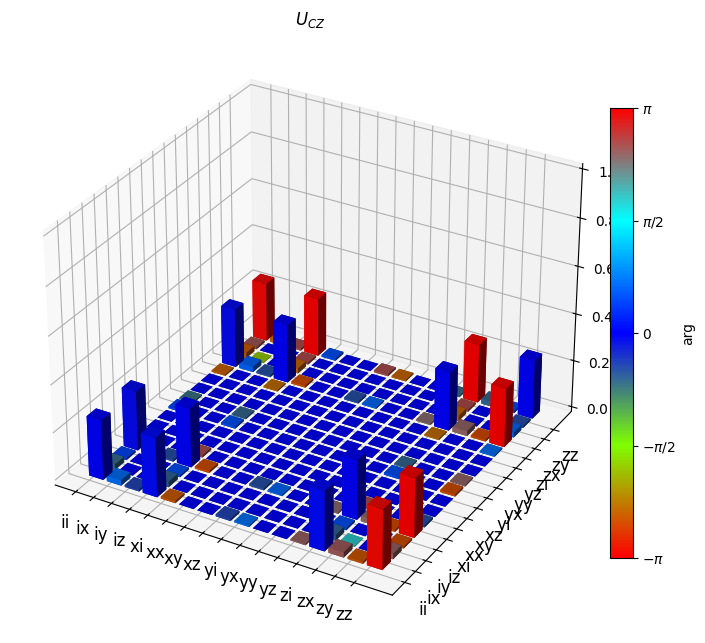

In [359]:
from qutip.tomography import qpt, qpt_plot_combined

U_rho = spre(Uphase) * spost(Uphase.dag())
op_basis = [[qeye(2), sigmax(), sigmay(), sigmaz()]] * 2
op_label = [["i", "x", "y", "z"]] * 2
chi = qpt(U_rho, op_basis)
fig = qpt_plot_combined(chi, op_label, r'$U_{CZ}$')
%matplotlib inline
plt.show()

#### Cal ideal Cphase

In [513]:
Uphase_ideal_matrix = np.array([[1,0,0,0], 
              [0, 1, 0, 0],
              [0,0, 1, 0],
              [0,0,0, np.exp(1j*(np.pi))]])
Uphase_ideal = Qobj(Uphase_ideal_matrix, dims= [[2,2], [2,2]])
Uphase_ideal

Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = True
Qobj data =
[[ 1.+0.0000000e+00j  0.+0.0000000e+00j  0.+0.0000000e+00j
   0.+0.0000000e+00j]
 [ 0.+0.0000000e+00j  1.+0.0000000e+00j  0.+0.0000000e+00j
   0.+0.0000000e+00j]
 [ 0.+0.0000000e+00j  0.+0.0000000e+00j  1.+0.0000000e+00j
   0.+0.0000000e+00j]
 [ 0.+0.0000000e+00j  0.+0.0000000e+00j  0.+0.0000000e+00j
  -1.+1.2246468e-16j]]

In [ ]:
pickle.dump(Uphase_ideal_matrix, open('../../../Data/Uphase_ideal_4spin.pkl', 'wb'))

#### Load ideal Uphase and calculate fidelity

In [278]:
Uphase_ideal_matrix = pickle.load(open('../../../Data/Uphase_ideal_4spin.pkl', 'rb'))
Uphase_ideal = Qobj(Uphase_ideal_matrix, dims= [[2,2], [2,2]])
Uphase_ideal

Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = False
Qobj data =
[[1.        +0.j         0.        +0.j         0.        +0.j
  0.        +0.j        ]
 [0.        +0.j         1.        +0.j         0.        +0.j
  0.        +0.j        ]
 [0.        +0.j         0.        +0.j         1.        +0.j
  0.        +0.j        ]
 [0.        +0.j         0.        +0.j         0.        +0.j
  0.85793813+0.51375303j]]

In [414]:
# f = (1/4*(Uphase_ideal*Uphase.dag()).tr())
f = average_gate_fidelity(Uphase, Uphase_ideal)
# f = process_fidelity(Uphase, Uphase_ideal, normalize=True) # (U1 * U2).tr() / (U1.tr() * U2.tr())
f = abs(f)
print('Fidelity:{: .10%}'.format(f))##### fidelity


Fidelity: 99.9994348747%


## Ideal physical 4-spin case


In [60]:
freq_list = [ # GHz
    [0, 10.35],
    [0, 10],
    [0, 10.25],
    [0, 10.15]
]
inter_list = [
    [{
        "v01": 0,
        "v00": 1,
        "v11": -1
    },
    {
        "v01": 0,
        "v00": 1,
        "v11": -1
    }
    ,
    {
        "v01": 0,
        "v00": 1,
        "v11": -1
    },
    {
        "v01": 0,
        "v00": 1,
        "v11": -1
    }]
    ,
    [{
        "v01": 1,
        "v00": 0,
        "v11": 0
    },
    {
        "v01": 1,
        "v00": 0,
        "v11": 0
    }
    ,
    {
        "v01": 1,
        "v00": 0,
        "v11": 0
    },
    {
        "v01": 1,
        "v00": 0,
        "v11": 0
    }]
    ,
    [{
        "v01": -1j,
        "v00": 0,
        "v11": 0
    },
    {
        "v01": -1j,
        "v00": 0,
        "v11": 0
    }
    ,
    {
        "v01": -1j,
        "v00": 0,
        "v11": 0
    },
    {
        "v01": -1j,
        "v00": 0,
        "v11": 0
    }]
]
r_dic = { # 04/12/24 change residual coupling
    "r12": 1e-3,
    "r23": 1e-3,
    "r34": 1e-3
}
r = tools.r2matrix(r_dic, freq_list) 
extra_list=None
driving_list = [
    {
        "W01": 1j   # W01 represents \Omega_{01}, for the qubit with index 0
    },
    {
        "W01": 1j
    },
    {
        "W01": 1j
    },
    {
        "W01": 1j
    }
]
bias_list = [ 
    {
        "Z11": 1
    },
    {
        "Z11": 1
    },
    {
        "Z11": 1
    },
    {
        "Z11": 1
    }
]

gamma_list = None

_system_arb1 = aqs.arb_qubit_system(freq_list, inter_list, r, extra_list, gamma_list, driving_list, bias_list)

state_0000, E_0000, _= _system_arb1.get_eigenstates_energy((0,0,0,0))

state_0001, E_0001, _= _system_arb1.get_eigenstates_energy((0,0,0,1))
state_0010, E_0010, _= _system_arb1.get_eigenstates_energy((0,0,1,0))
state_0100, E_0100, _= _system_arb1.get_eigenstates_energy((0,1,0,0))
state_1000, E_1000, _= _system_arb1.get_eigenstates_energy((1,0,0,0))

"""subspace"""
state_0101, E_0101, index_0101= _system_arb1.get_eigenstates_energy((0,1,0,1))
state_1001, E_1001, index_1001= _system_arb1.get_eigenstates_energy((1,0,0,1))
state_0110, E_0110, index_0110= _system_arb1.get_eigenstates_energy((0,1,1,0))
state_1010, E_1010, index_1010= _system_arb1.get_eigenstates_energy((1,0,1,0))

"""leakage"""
state_0011, E_0011, index_0011= _system_arb1.get_eigenstates_energy((0,0,1,1))
state_1100, E_1100, index_1100= _system_arb1.get_eigenstates_energy((1,1,0,0))

state_0111, E_0111, _= _system_arb1.get_eigenstates_energy((0,1,1,1))
state_1011, E_1011, _= _system_arb1.get_eigenstates_energy((1,0,1,1))
state_1101, E_1101, _= _system_arb1.get_eigenstates_energy((1,1,0,1))
state_1110, E_1110, _= _system_arb1.get_eigenstates_energy((1,1,1,0))

state_1111, E_1111, _= _system_arb1.get_eigenstates_energy((1,1,1,1))

state_ud = Qobj(np.array([0,0,1,0]), dims = [[2, 2], [1, 1]], shape = (4, 1), type = ket)
state_du = Qobj(np.array([0,1,0,0]), dims = [[2, 2], [1, 1]], shape = (4, 1), type = ket)

state_dudu = tensor(state_du,state_du)
state_duud = tensor(state_du,state_ud)
state_uddu = tensor(state_ud,state_du)
state_udud = tensor(state_ud,state_ud)

_system_arb1.H

Quantum object: dims = [[2, 2, 2, 2], [2, 2, 2, 2]], shape = (16, 16), type = oper, isherm = True
Qobj data =
[[1.88495559e-02 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 6.37806141e+01 1.25663706e-02 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.25663706e-02 6.43963662e+01 0.00000000e+00
  1.25663706e-02 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 1.28183263e+02
  0.00000000e+00 1.25663706e-02 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.

### Setup pulse

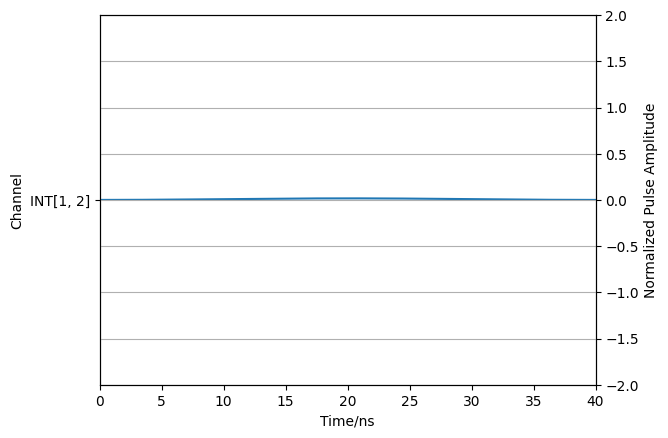

0

In [61]:
# t_width = 150; bisa_amp = 14.106e-3 
# or maybe 14.128e-3? as the baseline changed
bisa_amp = 16.8045e-3; t_width = 40

simulation_option = {
    "simulation_time": t_width, # ns
    "simulation_step": 10000,
    "initial_state": [state_dudu, state_duud, state_uddu, state_udud] # Do multiple simulation
}

pulse_sequence = [
    {
        'pulse_index': 0, # [m,n] represents $\Omega_{mn}$
        'type': "INT",
        'pulse_shape': "cosine",
        't_delay': 0, # unit in ns
        't_width': t_width, # unit in ns
        't_plateau':simulation_option['simulation_time'] - t_width , # unit in ns
        'freq': 0, # unit in GHz; Z pulse does not use it
        'phase': 0, # unit in rad; Z pulse does not use it
        'amplitude': bisa_amp, # XY: Rabi freq; Z: biased frequency
        'q_index': [1,2]
    }
]

%matplotlib inline
## Notice that the all pulses'  amplitude are rescaled by a factor 1/1.2
pl.plot_pulse_sequence(pulse_sequence, simulation_option)

#### dynamics

In [62]:
result_list, angle_list = _system_arb1.system_dynamics_mesolve(simulation_option, pulse_sequence)
propa_list = _system_arb1.system_dynamics_propagator(simulation_option, pulse_sequence)
angle_list

12.5%. Run time:   5.72s. Est. time left: 00:00:00:40
25.0%. Run time:   6.37s. Est. time left: 00:00:00:19
31.2%. Run time:   6.67s. Est. time left: 00:00:00:14
43.8%. Run time:   6.84s. Est. time left: 00:00:00:08
50.0%. Run time:   7.17s. Est. time left: 00:00:00:07
62.5%. Run time:   7.32s. Est. time left: 00:00:00:04
75.0%. Run time:   7.75s. Est. time left: 00:00:00:02
81.2%. Run time:   7.85s. Est. time left: 00:00:00:01
93.8%. Run time:   8.43s. Est. time left: 00:00:00:00
100.0%. Run time:   8.52s. Est. time left: 00:00:00:00
Total run time:   8.57s


[array([[3.36107332]]),
 array([[4.41706325]]),
 array([[4.43162958]]),
 array([[2.35124598]])]

#### partial trace of U

In [63]:
U = propa_list[-1] # get the Unitary 

# Perform partial trace, tracing out the coupler degree of freedom
slist = [
    state_dudu, state_duud, state_uddu, state_udud
]
sdlist = [
    state_dudu.dag(), state_duud.dag(), state_uddu.dag(), state_udud.dag()
]
dims = [len(sdlist), len(slist)];   umatrix = []
for i in range(dims[0]):
    umatrix_row = []
    for j in range(dims[1]):
        umatrix_row.append(sdlist[i] * U * slist[j])
    umatrix.append(umatrix_row)

Usim = Qobj(np.array(umatrix).reshape(dims[0],dims[1]), dims = [[int(np.sqrt(dims[0])), int(np.sqrt(dims[0]))], [int(np.sqrt(dims[1])), int(np.sqrt(dims[1]))]])
Usim = Usim/Usim.data[0,0]
Usim

Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = False
Qobj data =
[[ 1.00000000e+00+0.00000000e+00j -1.00648269e-02+1.72536467e-02j
  -2.95787652e-03+4.98544636e-03j  6.36514418e-05-2.94939365e-04j]
 [-1.00647533e-02+1.72536744e-02j  4.92386609e-01+8.70423874e-01j
   6.32146770e-05-2.95932949e-04j  2.26479642e-04-9.85896979e-03j]
 [-2.95779443e-03+4.98547397e-03j  6.32115195e-05-2.95933190e-04j
   4.79482343e-01+8.77185958e-01j  1.04564211e-03-3.44344624e-02j]
 [ 6.36457397e-05-2.94939834e-04j  2.26338483e-04-9.85895961e-03j
   1.04548912e-03-3.44344512e-02j  5.31819366e-01-8.46441478e-01j]]

#### Single qubit phase cancel


In [64]:

# Construct a decoupled system
r_dic = {
    "r12": 0,
    "r23": 0,
    "r34": 0
}
r = tools.r2matrix(r_dic, freq_list) # Coupling strength
extra_list=None
_system_arb2 = aqs.arb_qubit_system(freq_list, inter_list, r, extra_list, gamma_list, driving_list, bias_list)

simulation_option2 = copy.deepcopy(simulation_option)
simulation_option2['initial_state'] = [state_dudu, state_duud, state_uddu, state_udud] 
# simulation_option2['simulation_time'] = 112
pulse_sequence2 = [
    {
        'pulse_index': 1, # [m,n] represents $\Omega_{mn}$
        'type': "INT",
        'pulse_shape': "cosine",
        't_delay': 0, # unit in ns
        't_width': t_width, # unit in ns
        't_plateau':simulation_option2['simulation_time'] - t_width , # unit in ns
        'freq': 0, # unit in GHz; Z pulse does not use it
        'phase': 0, # unit in rad; Z pulse does not use it
        'amplitude': 0, # XY: Rabi freq; Z: biased frequency
        'q_index': [1,2]
    }
]


result_list2, angle_list2 = _system_arb2.system_dynamics_mesolve(simulation_option2, pulse_sequence2)
angle_list2

[array([[6.28303332]]),
 array([[6.28303175]]),
 array([[6.28302772]]),
 array([[6.28302608]])]

In [65]:
q_pmatrix = np.array([[np.exp(-1j*angle_list2[0][0][0]),0,0,0], 
              [0, np.exp(-1j*angle_list2[1][0][0]), 0, 0],
              [0,0, np.exp(-1j*angle_list2[2][0][0]), 0],
              [0,0,0, np.exp(-1j *angle_list2[3][0][0])]])
# single qubit rotation correcting phase gate during ZZ inter
q_phase_gate = Qobj(q_pmatrix,
              dims = [[2,2], [2,2]])
q_phase_gate = q_phase_gate/q_phase_gate.data[0,0]
q_phase_gate

Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = False
Qobj data =
[[1.+0.00000000e+00j 0.+0.00000000e+00j 0.+0.00000000e+00j
  0.+0.00000000e+00j]
 [0.+0.00000000e+00j 1.+1.56698767e-06j 0.+0.00000000e+00j
  0.+0.00000000e+00j]
 [0.+0.00000000e+00j 0.+0.00000000e+00j 1.+5.59723162e-06j
  0.+0.00000000e+00j]
 [0.+0.00000000e+00j 0.+0.00000000e+00j 0.+0.00000000e+00j
  1.+7.24011167e-06j]]

In [66]:
Usim_p = Usim * q_phase_gate
Usim_p

Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = False
Qobj data =
[[ 1.00000000e+00+0.00000000e+00j -1.00648539e-02+1.72536309e-02j
  -2.95790442e-03+4.98542980e-03j  6.36535772e-05-2.94938904e-04j]
 [-1.00647533e-02+1.72536744e-02j  4.92385245e-01+8.70424645e-01j
   6.32163334e-05-2.95932595e-04j  2.26551022e-04-9.85896815e-03j]
 [-2.95779443e-03+4.98547397e-03j  6.32119832e-05-2.95933091e-04j
   4.79477433e-01+8.77188642e-01j  1.04589142e-03-3.44344548e-02j]
 [ 6.36457397e-05-2.94939834e-04j  2.26353932e-04-9.85895926e-03j
   1.04568185e-03-3.44344453e-02j  5.31825495e-01-8.46437627e-01j]]

#### phase gate after ZZ inter

In [83]:
# Phase gate after ZZ inter, correcting single qubit phase
phi12 = -np.angle(Usim_p.data[1,1])
phi34 = -np.angle(Usim_p.data[2,2])
c_pmatrix = np.array([[1,0,0,0], 
              [0, np.exp(1j*phi12), 0, 0],
              [0,0, np.exp(1j*phi34), 0],
              [0,0,0, np.exp(1j *(phi12+phi34))]])
# correcting phase gate
c_phase_gate = Qobj(c_pmatrix,
              dims = [[2,2], [2,2]])
c_phase_gate

Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = False
Qobj data =
[[ 1.        +0.j          0.        +0.j          0.        +0.j
   0.        +0.j        ]
 [ 0.        +0.j          0.49236499-0.87038883j  0.        +0.j
   0.        +0.j        ]
 [ 0.        +0.j          0.        +0.j          0.47963129-0.87747013j
   0.        +0.j        ]
 [ 0.        +0.j          0.        +0.j          0.        +0.j
  -0.52758654-0.84950129j]]

In [84]:
Uphase = Usim_p * c_phase_gate
print(Uphase.data)

  (0, 0)	(1+0j)
  (0, 1)	(0.010061785987247513+0.017255420181696277j)
  (0, 2)	(0.0029558621933029766+0.0049866409127162096j)
  (0, 3)	(-0.0002841337500312727+0.00010153200103216652j)
  (1, 0)	(-0.01006475329187198+0.017253674354084887j)
  (1, 1)	(1.0000411455032545+0j)
  (1, 2)	(-0.00022935147939300195-0.00019740897734457261j)
  (1, 3)	(-0.008494731416366417+0.00500900353507172j)
  (2, 0)	(-0.0029577944257343975+0.00498547396548564j)
  (2, 1)	(-0.00022645349065247367-0.0002007260969215685j)
  (2, 2)	(0.9996792099299852+0j)
  (2, 3)	(-0.029803911992888066+0.017278668867488606j)
  (3, 0)	(6.364573968789983e-05-0.0002949398340187128j)
  (3, 1)	(-0.008469679289489081-0.00505122227953433j)
  (3, 2)	(-0.029713655345107157-0.017433392158509146j)
  (3, 3)	(-0.9996338294900359-0.005217341529214825j)


#### Ideal gate

In [85]:
Uphase_ideal_matrix = np.array([[1,0,0,0], 
              [0, 1, 0, 0],
              [0,0, 1, 0],
              [0,0,0, np.exp(1j*(np.pi))]])
Uphase_ideal = Qobj(Uphase_ideal_matrix, dims= [[2,2], [2,2]])
Uphase_ideal

Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = True
Qobj data =
[[ 1.+0.0000000e+00j  0.+0.0000000e+00j  0.+0.0000000e+00j
   0.+0.0000000e+00j]
 [ 0.+0.0000000e+00j  1.+0.0000000e+00j  0.+0.0000000e+00j
   0.+0.0000000e+00j]
 [ 0.+0.0000000e+00j  0.+0.0000000e+00j  1.+0.0000000e+00j
   0.+0.0000000e+00j]
 [ 0.+0.0000000e+00j  0.+0.0000000e+00j  0.+0.0000000e+00j
  -1.+1.2246468e-16j]]

In [86]:
# f = (1/4*(Uphase_ideal*Uphase.dag()).tr())
f = average_gate_fidelity(Uphase, Uphase_ideal)
# f = process_fidelity(Uphase, Uphase_ideal, normalize=True) # (U1 * U2).tr() / (U1.tr() * U2.tr())
f = abs(f)
print('Fidelity:{: .10%}'.format(f))##### fidelity

Fidelity: 99.9743055856%


## Repeat simulation

In [3]:
freq_list = [ # GHz
    [0, 10.35],
    [0, 10],
    [0, 10.25],
    [0, 10.15]
]

inter_list = [
    [{
        "v01": 0,
        "v00": 1,
        "v11": -1
    },
    {
        "v01": 0,
        "v00": 1,
        "v11": -1
    }
    ,
    {
        "v01": 0,
        "v00": 1,
        "v11": -1
    },
    {
        "v01": 0,
        "v00": 1,
        "v11": -1
    }],
    [{
        "v01": 1,
        "v00": 0,
        "v11": 0
    },
    {
        "v01": 1,
        "v00": 0,
        "v11": 0
    }
    ,
    {
        "v01": 1,
        "v00": 0,
        "v11": 0
    },
    {
        "v01": 1,
        "v00": 0,
        "v11": 0
    }]
    ,
    [{
        "v01": -1j,
        "v00": 0,
        "v11": 0
    },
    {
        "v01": -1j,
        "v00": 0,
        "v11": 0
    }
    ,
    {
        "v01": -1j,
        "v00": 0,
        "v11": 0
    },
    {
        "v01": -1j,
        "v00": 0,
        "v11": 0
    }]
]

r_dic = {
    "r12": 4e-3,
    "r23": 4e-3,
    "r34": 4e-3
}
r = tools.r2matrix(r_dic, freq_list) # Coupling strength

extra_list=None
## with pulse type XY
driving_list = [
    {
        "W01": 1j   # W01 represents \Omega_{01}, for the qubit with index 0
    },
    {
        "W01": 1j
    },
    {
        "W01": 1j
    },
    {
        "W01": 1j
    }
]

## with pulse type Z
bias_list = [ # Default, Z00 = 0
    {
        "Z11": 1
    },
    {
        "Z11": 1
    },
    {
        "Z11": 1
    },
    {
        "Z11": 1
    }
]

gamma_list = None

# gamma_list = None

_system_arb1 = aqs.arb_qubit_system(freq_list, inter_list, r, extra_list, gamma_list, driving_list, bias_list)

state_0000, E_0000, _= _system_arb1.get_eigenstates_energy((0,0,0,0))

state_0001, E_0001, _= _system_arb1.get_eigenstates_energy((0,0,0,1))
state_0010, E_0010, _= _system_arb1.get_eigenstates_energy((0,0,1,0))
state_0100, E_0100, _= _system_arb1.get_eigenstates_energy((0,1,0,0))
state_1000, E_1000, _= _system_arb1.get_eigenstates_energy((1,0,0,0))

"""subspace"""
state_0101, E_0101, index_0101= _system_arb1.get_eigenstates_energy((0,1,0,1))
state_1001, E_1001, index_1001= _system_arb1.get_eigenstates_energy((1,0,0,1))
state_0110, E_0110, index_0110= _system_arb1.get_eigenstates_energy((0,1,1,0))
state_1010, E_1010, index_1010= _system_arb1.get_eigenstates_energy((1,0,1,0))

"""leakage"""
state_0011, E_0011, index_0011= _system_arb1.get_eigenstates_energy((0,0,1,1))
state_1100, E_1100, index_1100= _system_arb1.get_eigenstates_energy((1,1,0,0))

state_0111, E_0111, _= _system_arb1.get_eigenstates_energy((0,1,1,1))
state_1011, E_1011, _= _system_arb1.get_eigenstates_energy((1,0,1,1))
state_1101, E_1101, _= _system_arb1.get_eigenstates_energy((1,1,0,1))
state_1110, E_1110, _= _system_arb1.get_eigenstates_energy((1,1,1,0))

state_1111, E_1111, _= _system_arb1.get_eigenstates_energy((1,1,1,1))

repeat_time = 200
bisa_amp = 11.128e-3; t_width = 40

_system_arb1.H

Quantum object: dims = [[2, 2, 2, 2], [2, 2, 2, 2]], shape = (16, 16), type = oper, isherm = True
Qobj data =
[[7.53982237e-02 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 6.37994636e+01 5.02654825e-02 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 5.02654825e-02 6.43775167e+01 0.00000000e+00
  5.02654825e-02 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 1.28202113e+02
  0.00000000e+00 5.02654825e-02 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.

In [532]:
# Construct a decoupled system
r_dic2 = {
    "r12": 0,
    "r23": 0,
    "r34": 0
}
r2 = tools.r2matrix(r_dic2, freq_list) # Coupling strength
extra_list=None
_system_arb2 = aqs.arb_qubit_system(freq_list, inter_list, r2, extra_list, gamma_list, driving_list, bias_list)
simulation_option = {
    "simulation_time": t_width, # ns
    "simulation_step": 10000,
    "initial_state": [state_0101, state_0110, state_1001, state_1010] # Do multiple simulation
}

"""subspace"""
state_0101, E_0101, index_0101= _system_arb1.get_eigenstates_energy((0,1,0,1))
state_1001, E_1001, index_1001= _system_arb1.get_eigenstates_energy((1,0,0,1))
state_0110, E_0110, index_0110= _system_arb1.get_eigenstates_energy((0,1,1,0))
state_1010, E_1010, index_1010= _system_arb1.get_eigenstates_energy((1,0,1,0))
simulation_option2 = copy.deepcopy(simulation_option)
simulation_option2['initial_state'] = [state_0101, state_0110, state_1001, state_1010]
# simulation_option2['simulation_time'] = 154
pulse_sequence2 = [
    {
        'pulse_index': 1, # [m,n] represents $\Omega_{mn}$
        'type': "INT",
        'pulse_shape': "cosine",
        't_delay': 0, # unit in ns
        't_width': t_width, # unit in ns
        't_plateau':simulation_option2['simulation_time'] - t_width , # unit in ns
        'freq': 0, # unit in GHz; Z pulse does not use it
        'phase': 0, # unit in rad; Z pulse does not use it
        'amplitude': 0, # XY: Rabi freq; Z: biased frequency
        'q_index': (1,2)
    }
]

print(f'Subspace: index1010={index_1010}, index1001={index_1001}, Eindex0110={index_0110}, index0101={index_0101}')
print(f'Leakage space: index0011={index_0011}, index1100={index_1100}')

result_list2, angle_list2 = _system_arb2.system_dynamics_mesolve(simulation_option2, pulse_sequence2)

q_pmatrix = np.array([[np.exp(-1j*angle_list2[0][0][0]),0,0,0], 
              [0, np.exp(-1j*angle_list2[1][0][0]), 0, 0],
              [0,0, np.exp(-1j*angle_list2[2][0][0]), 0],
              [0,0,0, np.exp(-1j *angle_list2[3][0][0])]])
# single qubit rotation correcting phase gate during ZZ inter
q_phase_gate = Qobj(q_pmatrix,
              dims = [[2,2], [2,2]])
q_phase_gate = q_phase_gate/q_phase_gate.data[0,0]
q_phase_gate

Subspace: index1010=10, index1001=9, Eindex0110=6, index0101=5
Leakage space: index0011=8, index1100=7


Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = False
Qobj data =
[[1.+0.00000000e+00j 0.+0.00000000e+00j 0.+0.00000000e+00j
  0.+0.00000000e+00j]
 [0.+0.00000000e+00j 1.+1.80387286e-06j 0.+0.00000000e+00j
  0.+0.00000000e+00j]
 [0.+0.00000000e+00j 0.+0.00000000e+00j 1.+5.48018416e-06j
  0.+0.00000000e+00j]
 [0.+0.00000000e+00j 0.+0.00000000e+00j 0.+0.00000000e+00j
  1.+7.04409868e-06j]]

In [533]:
leakage_to_0011 = []; leakage_to_1100=[]; angle_cphase=[]; Cphase_melements = []; Fd_avg = []; Fd_process = []

noise_chan1 = [
    {
    'type': 'white',
    'switch': 'on',
    'std': 1.43e-3,
    }
]
noise_chan2 = [
    {
    'type': 'gaussian',
    'switch': 'on',
    'mean': 0,
    'std': 1/(785),
    }
]
noise_chan3 = [
    {
    'type': '1/f',
    'switch': 'on',
    'scale': 0.0045,
    'alpha': 1.2,
    }
]
noise_chan4 = [
    {
    'type': '1/f',
    'switch': 'on',
    'scale': 0.0045,
    'alpha': 1.2,
    }
]

Uphase_ideal_matrix = np.array([[1,0,0,0], 
              [0, 1, 0, 0],
              [0,0, 1, 0],
              [0,0,0, np.exp(1j*(np.pi))]])
Uphase_ideal = Qobj(Uphase_ideal_matrix, dims= [[2,2], [2,2]])

for rtime in tqdm(range(repeat_time)):
    pulse_sequence = [
        {
            'pulse_index': 0, # [m,n] represents $\Omega_{mn}$
            'type': "INT",
            'pulse_shape': "cosine",
            't_delay': 0, # unit in ns
            't_width': t_width, # unit in ns
            't_plateau':simulation_option['simulation_time'] - t_width , # unit in ns
            'freq': 0, # unit in GHz; Z pulse does not use it
            'phase': 0, # unit in rad; Z pulse does not use it
            'amplitude': bisa_amp, # XY: Rabi freq; Z: biased frequency
            'q_index': (1,2),
            'noise': noise_chan1
        },
        {
            'pulse_index': 1,
            'type': "Z",
            "pulse_shape": "square",
            't_delay': 0, # unit in ns
            't_width': 0, # unit in ns
            't_plateau':simulation_option['simulation_time'], # unit in ns
            'freq': 0, # unit in GHz; Z pulse does not use it
            'phase': 0, # unit in rad; Z pulse does not use it
            'amplitude': 0, # XY: Rabi freq; Z: biased frequency
            'q_index': 0,
            'noise': noise_chan2
        },
        {
            'pulse_index': 2,
            'type': "Z",
            "pulse_shape": "square",
            't_delay': 0, # unit in ns
            't_width': 0, # unit in ns
            't_plateau':simulation_option['simulation_time'], # unit in ns
            'freq': 0, # unit in GHz; Z pulse does not use it
            'phase': 0, # unit in rad; Z pulse does not use it
            'amplitude': 0, # XY: Rabi freq; Z: biased frequency
            'q_index': 1,
            'noise': noise_chan2
        },
        {
            'pulse_index': 3,
            'type': "Z",
            "pulse_shape": "square",
            't_delay': 0, # unit in ns
            't_width': 0, # unit in ns
            't_plateau':simulation_option['simulation_time'], # unit in ns
            'freq': 0, # unit in GHz; Z pulse does not use it
            'phase': 0, # unit in rad; Z pulse does not use it
            'amplitude': 0, # XY: Rabi freq; Z: biased frequency
            'q_index': 2,
            'noise': noise_chan2
        },
        {
            'pulse_index': 4,
            'type': "INT",
            "pulse_shape": "square",
            't_delay': 0, # unit in ns
            't_width': 0, # unit in ns
            't_plateau':simulation_option['simulation_time'], # unit in ns
            'freq': 0, # unit in GHz; Z pulse does not use it
            'phase': 0, # unit in rad; Z pulse does not use it
            'amplitude': 0, # XY: Rabi freq; Z: biased frequency
            'q_index': (0,1),
            'noise': noise_chan3
        },
        {
            'pulse_index': 5,
            'type': "INT",
            "pulse_shape": "square",
            't_delay': 0, # unit in ns
            't_width': 0, # unit in ns
            't_plateau':simulation_option['simulation_time'], # unit in ns
            'freq': 0, # unit in GHz; Z pulse does not use it
            'phase': 0, # unit in rad; Z pulse does not use it
            'amplitude': 0, # XY: Rabi freq; Z: biased frequency
            'q_index': (2,3),
            'noise': noise_chan3
        },
        {
            'pulse_index': 6,
            'type': "INT",
            "pulse_shape": "square",
            't_delay': 0, # unit in ns
            't_width': 0, # unit in ns
            't_plateau':simulation_option['simulation_time'], # unit in ns
            'freq': 0, # unit in GHz; Z pulse does not use it
            'phase': 0, # unit in rad; Z pulse does not use it
            'amplitude': 0, # XY: Rabi freq; Z: biased frequency
            'q_index': (1,2),
            'noise': noise_chan3
        }
    ]
    result_list, angle_list = _system_arb1.system_dynamics_mesolve(simulation_option, pulse_sequence)
    propa_list = _system_arb1.system_dynamics_propagator(simulation_option, pulse_sequence, do_progress_bar=None)
    dummy_list0011 = []; dummy_list1100 = []
    for i in range(len(simulation_option["initial_state"])):
        dummy_list0011.append(np.abs((state_0011.dag() * result_list[i].states[-1]).data[0,0]))
        dummy_list1100.append(np.abs((state_1100.dag() * result_list[i].states[-1]).data[0,0]))
    leakage_to_0011.append(dummy_list0011)
    leakage_to_1100.append(dummy_list1100)


    U = propa_list[-1] # get the Unitary 
    # Perform partial trace, tracing out the coupler degree of freedom
    slist = [
        state_0101, state_0110, state_1001, state_1010
    ]
    sdlist = [
        state_0101.dag(), state_0110.dag(), state_1001.dag(), state_1010.dag()
    ]
    dims = [len(sdlist), len(slist)];   umatrix = []
    for i in range(dims[0]):
        umatrix_row = []
        for j in range(dims[1]):
            umatrix_row.append(sdlist[i] * U * slist[j])
        umatrix.append(umatrix_row)

    Usim = Qobj(np.array(umatrix).reshape(dims[0],dims[1]), dims = [[int(np.sqrt(dims[0])), int(np.sqrt(dims[0]))], [int(np.sqrt(dims[1])), int(np.sqrt(dims[1]))]])
    Usim = Usim/Usim.data[0,0]
    Usim_p = Usim * q_phase_gate
    # Phase gate after ZZ inter, correcting single qubit phase
    # phi12 = -np.angle(Usim_p.data[1,1])
    # phi34 = -np.angle(Usim_p.data[2,2])
    # c_pmatrix = np.array([[1,0,0,0], 
    #             [0, np.exp(1j*phi12), 0, 0],
    #             [0,0, np.exp(1j*phi34), 0],
    #             [0,0,0, np.exp(1j *(phi12+phi34))]])
    # # correcting phase gate
    # c_phase_gate = Qobj(c_pmatrix,
    #             dims = [[2,2], [2,2]])
    Uphase = Usim_p * c_phase_gate

    angle_cphase.append(np.angle(Uphase.data[3,3]))
    Cphase_melements.append([Uphase.data[jj,jj] for jj in range(4)])
    process_fd = np.abs(process_fidelity(Uphase, Uphase_ideal, normalize=True))
    avg_fd = np.abs(average_gate_fidelity(Uphase, Uphase_ideal))
    if process_fd <= 1: Fd_process.append(process_fd)
    if avg_fd <= 1: Fd_avg.append(avg_fd)

100%|██████████| 200/200 [45:55<00:00, 13.78s/it]


In [534]:
data = [Fd_process, Fd_avg, pulse_sequence]
trail=2
pickle.dump(data, open(f'../../../Data/CZ_200trail_40ns_{trail}.pkl', 'wb'))

In [535]:
trail = 2
Fd_process, Fd_avg, pulse_sequence = pickle.load(open(f'../../../Data/CZ_200trail_40ns_{trail}.pkl', 'rb'))

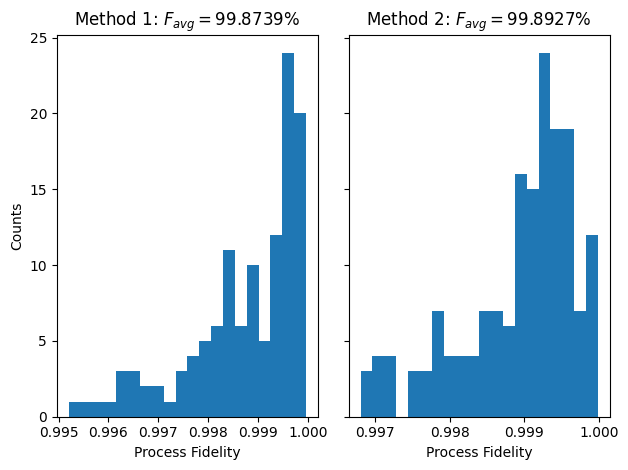

In [536]:
from matplotlib import colors
from matplotlib.ticker import PercentFormatter
n_bins = 20
fig, axs = plt.subplots(1, 2, sharey=True, tight_layout=True)

# We can set the number of bins with the *bins* keyword argument.
axs[0].hist(np.abs(Fd_avg), bins=n_bins)
axs[0].set_title(r'Method 1: $F_{avg} = $' +f'{np.average(np.abs(Fd_avg)):.4%}')
axs[0].set_xlabel("Process Fidelity")
axs[0].set_ylabel("Counts")
axs[1].hist(np.abs(Fd_process), bins=n_bins)
axs[1].set_title(r'Method 2: $F_{avg} = $' +f'{np.average(np.abs(Fd_process)):.4%}')
axs[1].set_xlabel("Process Fidelity")
plt.show()

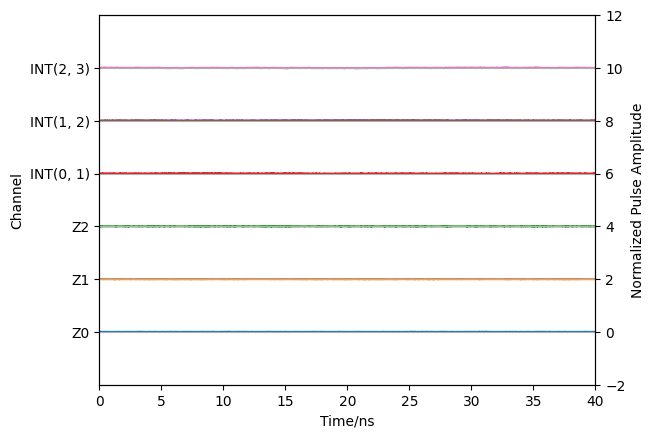

0

In [537]:
%matplotlib inline
## Notice that the all pulses'  amplitude are rescaled by a factor 1/1.2
pl.plot_pulse_sequence(pulse_sequence, simulation_option)

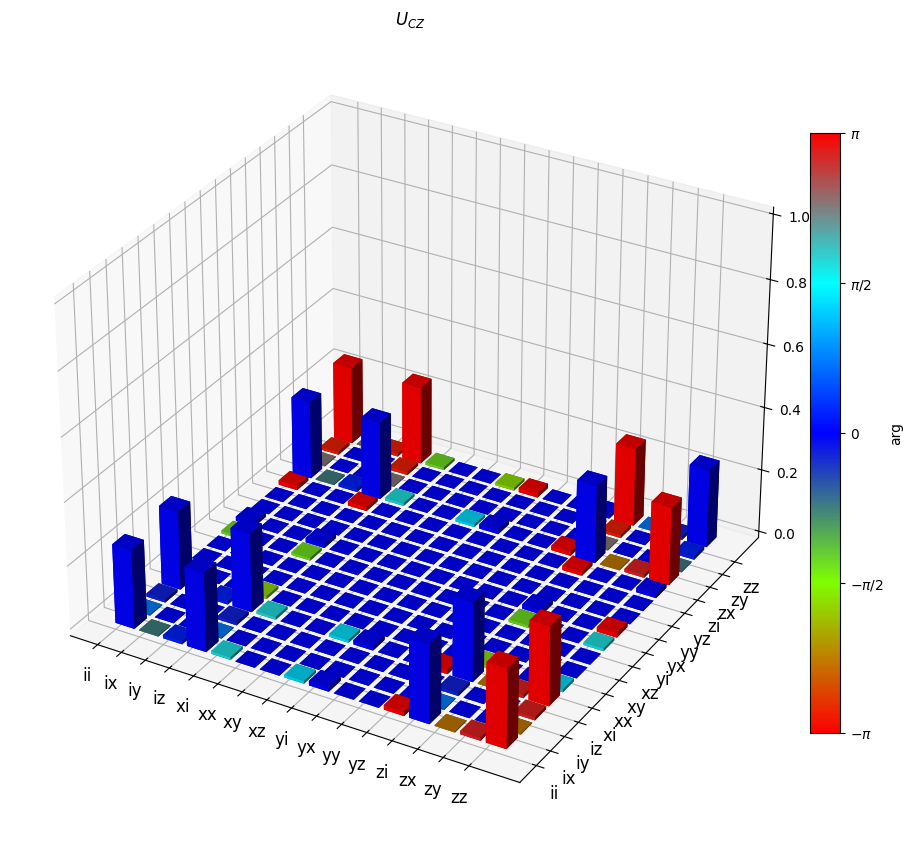

In [538]:
from qutip.tomography import qpt, qpt_plot_combined

U_rho = spre(Uphase) * spost(Uphase.dag())
op_basis = [[qeye(2), sigmax(), sigmay(), sigmaz()]] * 2
op_label = [["i", "x", "y", "z"]] * 2
chi = qpt(U_rho, op_basis)
fig = qpt_plot_combined(chi, op_label, r'$U_{CZ}$', figsize=(14,8))
%matplotlib inline
plt.show()

## Q factor measurement

In [13]:
freq_list = [ # GHz
    [0, 10],
    [0, 10.25]
]

inter_list = [
    [{
        "v01": 0,
        "v00": 1,
        "v11": -1
    },
    {
        "v01": 0,
        "v00": 1,
        "v11": -1
    }],
    [{
        "v01": 1,
        "v00": 0,
        "v11": 0
    },
    {
        "v01": 1,
        "v00": 0,
        "v11": 0
    }]
    ,
    [{
        "v01": -1j,
        "v00": 0,
        "v11": 0
    },
    {
        "v01": -1j,
        "v00": 0,
        "v11": 0
    }]
]

r_dic = {
    "r12": 1e-3
}
r = tools.r2matrix(r_dic, freq_list) # Coupling strength

extra_list=None
## with pulse type XY
driving_list = [
    {
        "W01": 1j   # W01 represents \Omega_{01}, for the qubit with index 0
    },
    {
        "W01": 1j
    }
]

## with pulse type Z
bias_list = [ # Default, Z00 = 0
    {
        "Z11": 1
    },
    {
        "Z11": 1
    }
]

gamma_list = [{"z":1/50}, {"z": 1/50}]
gamma_list = None

_system_arb1 = aqs.arb_qubit_system(freq_list, inter_list, extra_list=extra_list, r =r, driving_list=driving_list, bias_list=bias_list, gamma_list=gamma_list)

# System initial state & eigenstate
state_00, E_00, _= _system_arb1.get_eigenstates_energy((0,0))
state_10, E_10, _= _system_arb1.get_eigenstates_energy((1,0))
state_01, E_01, _= _system_arb1.get_eigenstates_energy((0,1))
state_11, E_11, _= _system_arb1.get_eigenstates_energy((1,1))

# spin basis
state_uu = state_11
state_dd = state_00
state_ud = Qobj(np.array([0,0,1,0]), dims = [[2, 2], [1, 1]], shape = (4, 1), type = ket)
state_du = Qobj(np.array([0,1,0,0]), dims = [[2, 2], [1, 1]], shape = (4, 1), type = ket)

# ST0
state_S = (state_ud-state_du)/np.sqrt(2)
state_T0 = (state_ud+state_du)/np.sqrt(2)

_system_arb1.H

Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = True
Qobj data =
[[6.28318531e-03 0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 6.43963662e+01 1.25663706e-02 0.00000000e+00]
 [0.00000000e+00 1.25663706e-02 6.28255699e+01 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 1.27240786e+02]]

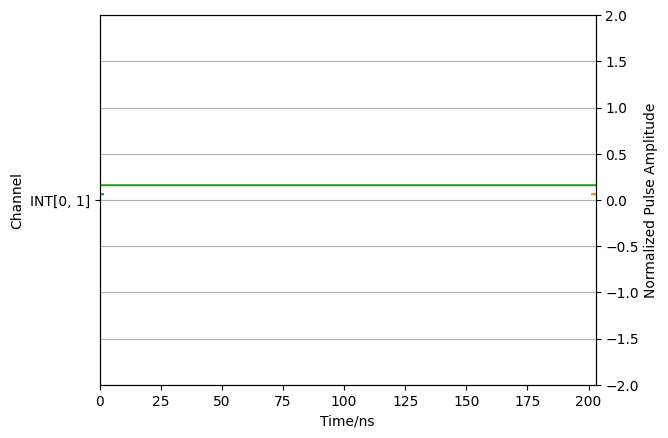

0

In [4]:
half_pi_gt = np.sqrt(2); tau_d=200
bisa_amp = 61.5e-3; t_width = tau_d + 2*half_pi_gt

simulation_option = {
    "simulation_time": t_width, # ns
    "simulation_step": 50000,
    "initial_state": [state_10, state_01] # Do multiple simulation
}

# noise_chan3 = [
#     {
#     'type': '1/f',
#     'switch': 'on',
#     'scale': 0.002,
#     'alpha': 1.2,
#     }
# ]

pulse_sequence = [
    {
        'pulse_index': 0, # [m,n] represents $\Omega_{mn}$
        'type': "INT",
        'pulse_shape': "square",
        't_delay': 0, # unit in ns
        't_width': half_pi_gt, # unit in ns
        't_plateau':0, # unit in ns
        'freq': 0, # unit in GHz; Z pulse does not use it
        'phase': 0, # unit in rad; Z pulse does not use it
        'amplitude': bisa_amp,#-3.5e-3, # bisa_amp, # XY: Rabi freq; Z: biased frequency
        'q_index': [0,1]
    },
    {
        'pulse_index': 1, # [m,n] represents $\Omega_{mn}$
        'type': "INT",
        'pulse_shape': "square",
        't_delay': half_pi_gt + tau_d, # unit in ns
        't_width': half_pi_gt, # unit in ns
        't_plateau':0, # unit in ns
        'freq': 0, # unit in GHz; Z pulse does not use it
        'phase': 0, # unit in rad; Z pulse does not use it
        'amplitude': bisa_amp,#-3.5e-3, # bisa_amp, # XY: Rabi freq; Z: biased frequency
        'q_index': [0,1]
    },
    { # Base line J23
        'pulse_index': 3,
        'type': "INT",
        "pulse_shape": "square",
        't_delay': 0, # unit in ns
        't_width': 0, # unit in ns
        't_plateau':simulation_option['simulation_time'], # unit in ns
        'freq': 0, # unit in GHz; Z pulse does not use it
        'phase': 0, # unit in rad; Z pulse does not use it
        'amplitude': np.random.normal(0, 90e-3),#j23_d*1e-3, # XY: Rabi freq; Z: biased frequency
        'q_index': [0,1],
    }
]

%matplotlib inline
## Notice that the all pulses'  amplitude are rescaled by a factor 1/1.2
pl.plot_pulse_sequence(pulse_sequence, simulation_option)

### Energy level

In [573]:
num_level = 4 # Num of level we want to see
j23_scan_space= np.linspace(0.01e-3, 300e-3, 1000)
j_dic =copy.deepcopy(r_dic)

energy_level_list = []
for j23 in j23_scan_space:
    dummy_list = []
    j_dic["r12"] = j23
    j_matrix = tools.r2matrix(j_dic, freq_list)
    _system_arb1 = aqs.arb_qubit_system(freq_list, inter_list, j_matrix, extra_list, gamma_list, driving_list, bias_list)
    for j in range(0,num_level):
        dummy_list.append((_system_arb1.H.eigenenergies()[j] / np.pi/2).real)
    energy_level_list.append(dummy_list)

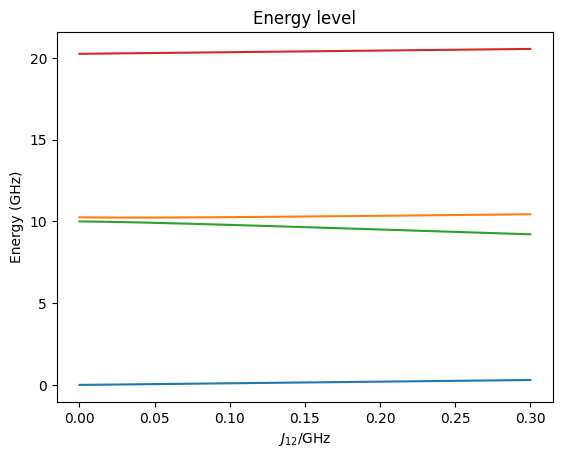

0

In [576]:
%matplotlib inline
pl.plot_Elevel_dynamics(j23_scan_space, energy_level_list, [index_00, index_01, index_10, index_11], "J_{12}")

### Single Mesolve

In [71]:
result_list, _ = _system_arb1.system_dynamics_mesolve(simulation_option, pulse_sequence)

#### Display data dm

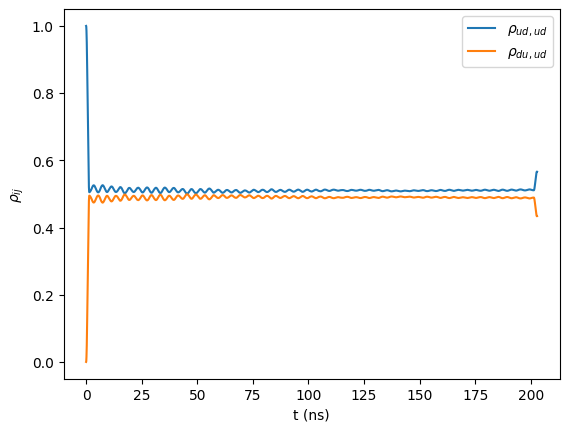

In [72]:
tlist = np.linspace(0, simulation_option['simulation_time'], simulation_option['simulation_step'])

# Select which result you want to see
result = result_list[0]

# Plot
%matplotlib inline
plt.plot(tlist,expect(result.states, ket2dm(state_ud)), label=r'$\rho_{ud,ud}$');
plt.plot(tlist,expect(result.states, ket2dm(state_du)), label=r'$\rho_{du,ud}$');
plt.ylabel(r"$\rho_{ij}$")
plt.xlabel("t (ns)")
plt.legend()
plt.show()

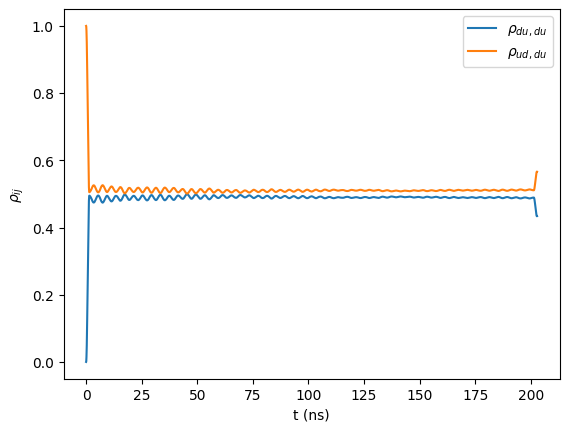

In [73]:
plt.plot(tlist,expect(result.states, ket2dm(state_du)), label=r'$\rho_{du,du}$');
plt.plot(tlist,expect(result.states, ket2dm(state_ud)), label=r'$\rho_{ud,du}$');
plt.ylabel(r"$\rho_{ij}$")
plt.xlabel("t (ns)")
plt.legend()
plt.show()

### Solve ME multiple time

In [85]:
repeat_time = 100
initial01_track10 = []; initial01_track01 = []; initial10_track01 = []; initial10_track10 = []
for trail in tqdm(range(repeat_time)):
    result_list, _ = _system_arb1.system_dynamics_mesolve(simulation_option, pulse_sequence)
    initial01_track10_d = []; initial01_track01_d = []; initial10_track01_d = []; initial10_track10_d = []
    for st in range(len(result_list[0].states)):
        initial01_track10_d.append( np.abs( (state_10.dag() * result_list[0].states[st]).data[0,0] ))
        initial01_track01_d.append( np.abs( (state_01.dag() * result_list[0].states[st]).data[0,0] ))
        initial10_track01_d.append( np.abs( (state_01.dag() * result_list[1].states[st]).data[0,0] ))
        initial10_track10_d.append( np.abs( (state_10.dag() * result_list[1].states[st]).data[0,0] ))
    initial01_track10.append(initial01_track10_d)
    initial01_track01.append(initial01_track01_d)
    initial10_track01.append(initial10_track01_d)
    initial10_track10.append(initial10_track10_d)
initial01_track10 = np.average(initial01_track10, axis=0)
initial01_track01 = np.average(initial01_track01, axis=0)
initial10_track01 = np.average(initial10_track01, axis=0)
initial10_track10 = np.average(initial10_track10, axis=0)
data = [initial01_track10, initial01_track01, initial10_track01, initial10_track10, pulse_sequence]

  0%|          | 0/100 [00:00<?, ?it/s]

100%|██████████| 100/100 [43:31<00:00, 26.11s/it]


In [86]:
trail =7
pickle.dump(data, open(f'../../../Data/Qfactor_measure_{trail}.pkl', 'wb'))

In [271]:
trail = 2
data = pickle.load(open(f'../../../Data/Qfactor_measure_{trail}.pkl', 'rb'))
initial01_track10, initial01_track01, initial10_track01, initial10_track10 = data

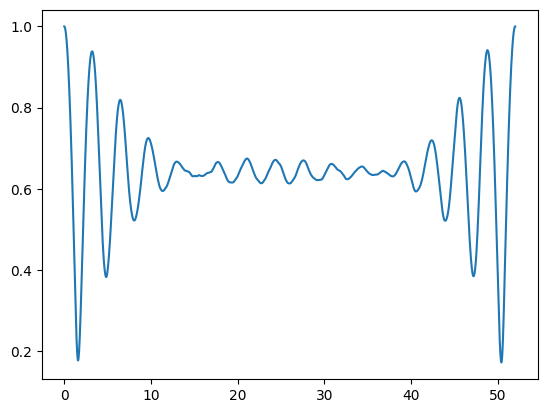

In [272]:
tlist = np.linspace(0, simulation_option["simulation_time"], simulation_option["simulation_step"])
%matplotlib inline
plt.plot(tlist,initial01_track01)
plt.show()

### Mesolve Ramsy

In [14]:
repeat_time = 200
tau_list = np.linspace(0, 500, 500)
# ep_list= np.linspace(100,0, 10)
ep_list= np.linspace(10,10, 1)
j23_list = 10*np.exp(-ep_list/10)
ramsy_pop = []
half_pi_gt = np.sqrt(2)
bisa_amp = 61.5e-3

for tau_d in tqdm(tau_list):
    dummy_list = []
    for j23_d in tqdm(j23_list, leave=None):
        total_t = tau_d + 2*half_pi_gt
        simulation_option = {
            "simulation_time": total_t, # ns
            "simulation_step": 10000,
            "initial_state": [state_10] # Do multiple simulation
        }
        
        initial01_track01 = []
        for trial in range(repeat_time):

            pulse_sequence = [
                {
                    'pulse_index': 0, # [m,n] represents $\Omega_{mn}$
                    'type': "INT",
                    'pulse_shape': "square",
                    't_delay': 0, # unit in ns
                    't_width': half_pi_gt, # unit in ns
                    't_plateau':0, # unit in ns
                    'freq': 0, # unit in GHz; Z pulse does not use it
                    'phase': 0, # unit in rad; Z pulse does not use it
                    'amplitude': bisa_amp,#-3.5e-3, # bisa_amp, # XY: Rabi freq; Z: biased frequency
                    'q_index': [0,1]
                },
                {
                    'pulse_index': 1, # [m,n] represents $\Omega_{mn}$
                    'type': "INT",
                    'pulse_shape': "square",
                    't_delay': half_pi_gt + tau_d, # unit in ns
                    't_width': half_pi_gt, # unit in ns
                    't_plateau':0, # unit in ns
                    'freq': 0, # unit in GHz; Z pulse does not use it
                    'phase': 0, # unit in rad; Z pulse does not use it
                    'amplitude': bisa_amp,#-3.5e-3, # bisa_amp, # XY: Rabi freq; Z: biased frequency
                    'q_index': [0,1]
                },
                { # Base line J23
                    'pulse_index': 3,
                    'type': "INT",
                    "pulse_shape": "square",
                    't_delay': 0, # unit in ns
                    't_width': 0, # unit in ns
                    't_plateau':simulation_option['simulation_time'], # unit in ns
                    'freq': 0, # unit in GHz; Z pulse does not use it
                    'phase': 0, # unit in rad; Z pulse does not use it
                    'amplitude': np.random.normal(0, 90e-3),#j23_d*1e-3, # XY: Rabi freq; Z: biased frequency
                    'q_index': [0,1]
                }
            ]

            result_list, _ = _system_arb1.system_dynamics_mesolve(simulation_option, pulse_sequence)
            initial01_track01.append( np.abs( (state_ud.dag() * result_list[0].states[-1]).data[0,0] ))
            # initial01_track01.append(expect(result_list[0].states[-1], ket2dm(state_ud)))
        avg_pop = np.average(initial01_track01)
        dummy_list.append(avg_pop)
    ramsy_pop.append(dummy_list)
data = [ramsy_pop, tau_list, j23_list, ep_list, [half_pi_gt, repeat_time]]

  0%|          | 0/500 [00:00<?, ?it/s]

 17%|█▋        | 84/500 [4:56:10<35:24:41, 306.44s/it]

In [ ]:
trail =13
pickle.dump(data, open(f'../../../Data/Qfactor_ramsy_StateS_{trail}.pkl', 'wb'))

In [11]:
trail = 10
data = pickle.load(open(f'../../../Data/Qfactor_ramsy_{trail}.pkl', 'rb'))
# ramsy_pop, tau_list, j23_list, ep_list = data
ramsy_pop, tau_list, j23_list, ep_list, aa = data

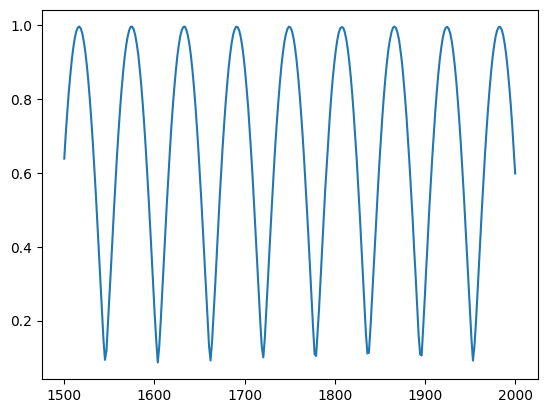

In [12]:
# tlist = np.linspace(0, simulation_option["simulation_time"], simulation_option["simulation_step"])
plt.plot(tau_list,ramsy_pop)
plt.show()

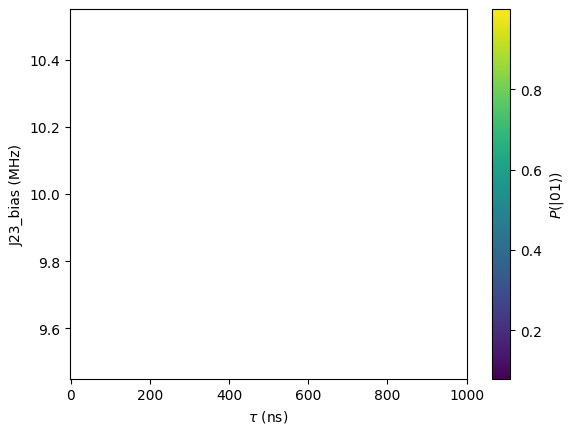

In [277]:
tau_listd, ep_listd = np.meshgrid(tau_list, ep_list)

plt.figure()
# plt.plot(t_width_scan_rng[min_index[1]],j23bias_scan_rng[min_index[0]]*1e3, '*', color='r')
plt.pcolormesh(np.transpose(tau_listd), np.transpose(ep_listd), ramsy_pop)
plt.colorbar(label=r'$P(|01\rangle)$')
plt.xlabel(r'$\tau$ (ns)')
plt.ylabel('J23_bias (MHz)')
plt.show()

### Display data

In [58]:
# state that you want to plot each simulation
interested_state = [
                    [state_ud, state_du], [state_ud, state_du]
                    ]
# Convert the variable name to string in order to make legend in the plot
interested_state_label = var_name2str(interested_state)
initial_state_label = var_name2str(simulation_option["initial_state"])

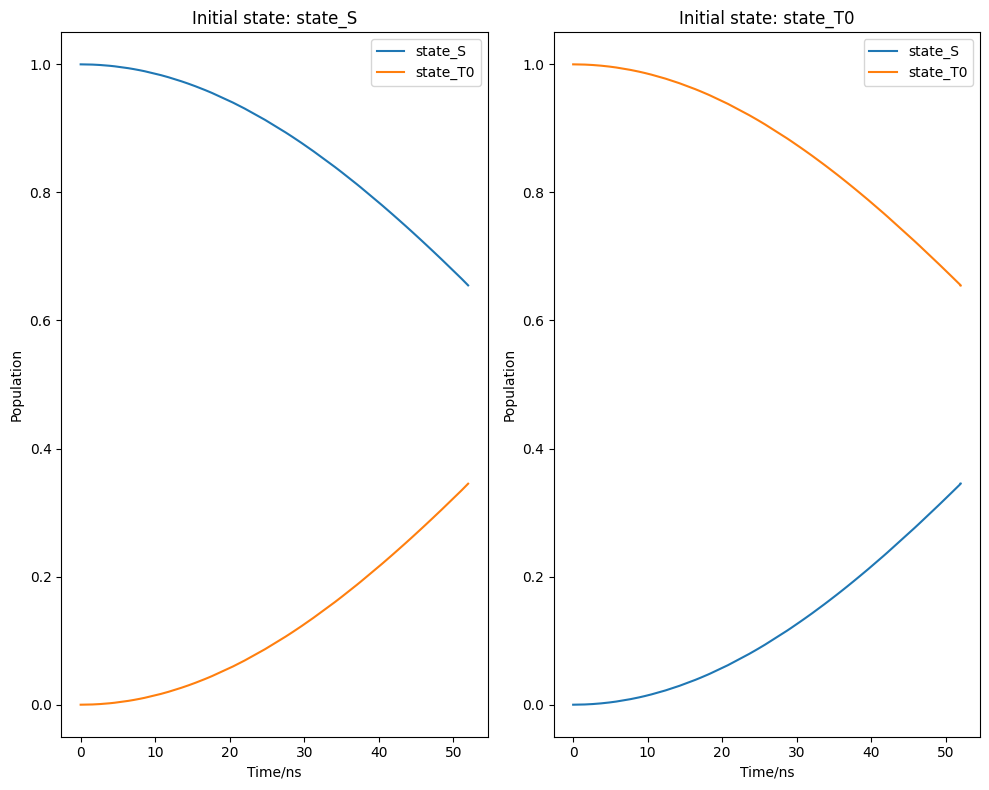

0

In [59]:
%matplotlib inline
# plot state population evolution
pl.plot_population_evolution(_system_arb1, result_list, simulation_option, interested_state, interested_state_label, initial_state_label)

## Single Qubit gate calibration 

In [11]:
freq_list = [ # GHz
    [0, 10],
    [0, 10.25]
]

inter_list = [
    [{
        "v01": 0,
        "v00": 1,
        "v11": -1
    },
    {
        "v01": 0,
        "v00": 1,
        "v11": -1
    }],
    [{
        "v01": 1,
        "v00": 0,
        "v11": 0
    },
    {
        "v01": 1,
        "v00": 0,
        "v11": 0
    }]
    ,
    [{
        "v01": -1j,
        "v00": 0,
        "v11": 0
    },
    {
        "v01": -1j,
        "v00": 0,
        "v11": 0
    }]
]

r_dic = {
    "r12": 1e-3
}
r = tools.r2matrix(r_dic, freq_list) # Coupling strength

extra_list=None
## with pulse type XY
driving_list = [
    {
        "W01": 1j   # W01 represents \Omega_{01}, for the qubit with index 0
    },
    {
        "W01": 1j
    }
]

## with pulse type Z
bias_list = [ # Default, Z00 = 0
    {
        "Z11": 1
    },
    {
        "Z11": 1
    }
]

gamma_list = [{"z":1/200}, {"z": 1/200}]

_system_arb1 = aqs.arb_qubit_system(freq_list, inter_list, extra_list=extra_list, r =r, driving_list=driving_list, bias_list=bias_list)

# System initial state & eigenstate
state_00, E_00, _= _system_arb1.get_eigenstates_energy((0,0))
state_10, E_10, _= _system_arb1.get_eigenstates_energy((1,0))
state_01, E_01, _= _system_arb1.get_eigenstates_energy((0,1))
state_11, E_11, _= _system_arb1.get_eigenstates_energy((1,1))

# spin basis
state_uu = state_11
state_dd = state_00
state_ud = Qobj(np.array([0,0,1,0]), dims = [[2, 2], [1, 1]], shape = (4, 1), type = ket)
state_du = Qobj(np.array([0,1,0,0]), dims = [[2, 2], [1, 1]], shape = (4, 1), type = ket)

# ST0
state_S = (state_ud-state_du)/np.sqrt(2)
state_T0 = (state_ud+state_du)/np.sqrt(2)

_system_arb1.H

Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = True
Qobj data =
[[6.28318531e-03 0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 6.43963662e+01 1.25663706e-02 0.00000000e+00]
 [0.00000000e+00 1.25663706e-02 6.28255699e+01 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 1.27240786e+02]]

dBz = 2.4MHz, residual =  1.xx MHz H gate

dBz = 2.9 MHz, residual = 1.xx MHz I gate

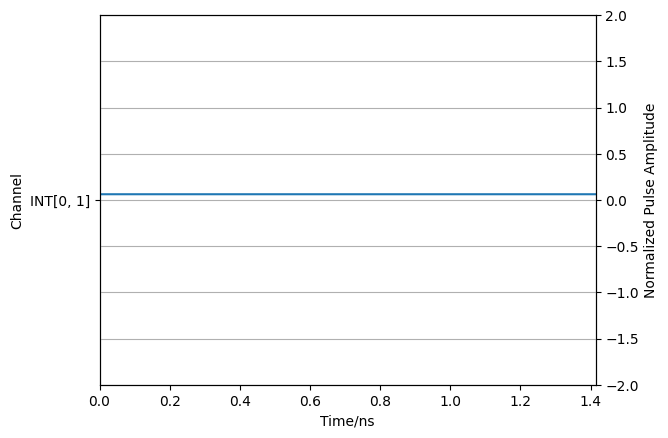

0

In [51]:
half_pi_gt = np.sqrt(2)
bias_amp = 61.5e-3


simulation_option = {
    "simulation_time": half_pi_gt, # ns
    "simulation_step": 5000,
    "initial_state": [state_S, state_T0] # Do multiple simulation
}

pulse_sequence = [
    { # resitual coupling
        'pulse_index': 0,
        'type': "INT",
        "pulse_shape": "square",
        't_delay': 0, # unit in ns
        't_width': 0, # unit in ns
        't_plateau':simulation_option['simulation_time'], # unit in ns
        'freq': 0, # unit in GHz; Z pulse does not use it
        'phase': 0, # unit in rad; Z pulse does not use it
        'amplitude': bias_amp, # XY: Rabi freq; Z: biased frequency
        'q_index': [0,1]
    }
]

%matplotlib inline
## Notice that the all pulses'  amplitude are rescaled by a factor 1/1.2
pl.plot_pulse_sequence(pulse_sequence, simulation_option)

In [52]:
result_list, _ = _system_arb1.system_dynamics_mesolve(simulation_option, pulse_sequence)
# state that you want to plot each simulation
interested_state = [
                    [state_T0, state_S], [state_T0, state_S]
                    ]
# Convert the variable name to string in order to make legend in the plot
interested_state_label = var_name2str(interested_state)
initial_state_label = var_name2str(simulation_option["initial_state"])

%matplotlib qt
# plot state population evolution
pl.plot_population_evolution(_system_arb1, result_list, simulation_option, interested_state, interested_state_label, initial_state_label)

0

In [ ]:
gt_list = np.linspace(5, 65, 100); dBz = 3.85e-3
pop_list = [[],[]]
for gt in tqdm(gt_list):
    simulation_option = {
        "simulation_time": gt, # ns
        "simulation_step": 10000,
        "initial_state": [state_S] # Do multiple simulation
    }

    pulse_sequence = [
        {
            'pulse_index': 0,
            'type': "INT",
            "pulse_shape": "square",
            't_delay': 0, # unit in ns
            't_width': 0, # unit in ns
            't_plateau':simulation_option['simulation_time'], # unit in ns
            'freq': 0, # unit in GHz; Z pulse does not use it
            'phase': 0, # unit in rad; Z pulse does not use it
            'amplitude': -0.15e-3, # XY: Rabi freq; Z: biased frequency
            'q_index': (0,1)
        },
        {
            'pulse_index': 1,
            'type': "Z",
            "pulse_shape": "square",
            't_delay': 0, # unit in ns
            't_width': 0, # unit in ns
            't_plateau':simulation_option['simulation_time'], # unit in ns
            'freq': 0, # unit in GHz; Z pulse does not use it
            'phase': 0, # unit in rad; Z pulse does not use it
            'amplitude': -0.25 + dBz, # XY: Rabi freq; Z: biased frequency
            'q_index': 1
        }
    ]
    result_list, _ = _system_arb1.system_dynamics_mesolve(simulation_option, pulse_sequence)
    pop_list[0].append(np.abs(( state_T0.dag() * result_list[0].states[-1]).data[0,0]))
    pop_list[1].append(np.abs(( state_S.dag() * result_list[0].states[-1]).data[0,0]))
    

In [ ]:
%matplotlib qt
plt.plot(gt_list, np.abs(pop_list[0]))
plt.plot(gt_list, np.abs(pop_list[1]))